In [1]:
import operator
import random
import pandas as pd
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from itertools import product
from collections import namedtuple
from abc import ABC, abstractmethod
from scipy.stats import beta

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize

from tqdm import tqdm

%matplotlib inline
sns.set()

# Необходимые функции и классы

In [39]:
def run_spec(spec):
    
    env_spec = spec['env']
    n_experiments = spec['n_experiments']
    n_action = env_spec['n_action']
    n_iter = env_spec['n_iter']
    env = Environment(bandits = BANDITS, **env_spec)
    alg_cnt = len(spec['alg'])
    results = [{
                'mean_reward': np.zeros(n_iter), 
                'mean_regret': np.zeros(n_iter), 
                'total_cnt': np.zeros(n_action),
                'cumulative_reward': np.zeros(n_iter),
                'actions_history': np.zeros((n_iter, n_action))
                } for i in range(alg_cnt)]
    
    for i in tqdm(range(n_experiments)):
        for a in range(alg_cnt):      
            bandit, _, _,  mean_rewards, mean_regrets, cumulative_reward, ids = \
                Experiment.run(env, generate_stats=False, **spec['alg'][a])
            results[a]['mean_reward']  = results[a]['mean_reward'] + (mean_rewards - results[a]['mean_reward']) / (i + 1)
            results[a]['mean_regret']  = results[a]['mean_regret'] + (mean_regrets - results[a]['mean_regret']) / (i + 1)
            results[a]['total_cnt']  = results[a]['total_cnt'] + (bandit.bandit_cnt - results[a]['total_cnt']) / (i + 1)
            results[a]['cumulative_reward']  = results[a]['cumulative_reward'] + (cumulative_reward - results[a]['cumulative_reward']) / (i + 1)

            for j, action_id in enumerate(ids):
                results[a]['actions_history'][j][action_id] += 1
    
    return results

In [219]:
class Bandit:
    __type__ = 'base'
    
    def __init__(self, action_cnt, **kwargs):
        assert action_cnt > 0, "Number of action must be greater than zero!"
        
        self.action_cnt = action_cnt
        self.reward_cnt = np.array([0.] * self.action_cnt)
        self.bandit_cnt = np.array([0] * self.action_cnt)
        self.regrets =  np.array([0.])
        self.reward_estimate = np.array([0.0] * self.action_cnt)
        self.mean_reward = 0.
        self.mean_regret = 0.
        self.accuracy = 0.
        self.pull_cnt = 0
        
    def update_estimates(self, a, r, regret, get_correct, **kwargs):
        self.bandit_cnt[a] += 1
        self.reward_cnt[a] += r
        np.append(self.regrets, regret)
        self.reward_estimate[a] = self.reward_estimate[a] + 1 / (self.bandit_cnt[a] + 1) * (r - self.reward_estimate[a])
        
        self.mean_reward = self.mean_reward + (r - self.mean_reward) / (self.pull_cnt + 1)
        self.mean_regret = self.mean_regret + (regret - self.mean_regret) / (self.pull_cnt + 1)
        self.accuracy = self.accuracy + (get_correct - self.accuracy) / (self.pull_cnt + 1)
        
    @abstractmethod
    def pull(self):
        pass
    
    def generate_stats(self, total_reward, total_regret, **kwrags):
        print('='*20,'STATS', '='*20)
        print(f'Type of the bandit: {self.__type__}'.center(20))
        print(f'Total reward: {total_reward}')
        print(f'Total regret: {total_regret}')
        print(f'Accuracy: {self.accuracy}')
        print(f'Bandits pull count: {self.bandit_cnt}')
        print(f'Reward from all bandit: {self.reward_cnt}')
        print(f'Reward estimate all bandit: {self.reward_estimate}')
        print('='*47)
    
class RandomBandit(Bandit):
    __type__ = 'random'
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def pull(self, **kwargs):
        a = np.random.randint(0, self.action_cnt)
        self.pull_cnt += 1
        return a
    
class UCB1_Bandit(Bandit):
    __type__ = 'ucb1'
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
        
    def pull(self, **kwargs):
        # сначала хотя бы раз пробуем каждый вариант
        for i in range(self.action_cnt):
            if self.bandit_cnt[i] == 0:
                return i
        total_cnt = np.sum(self.bandit_cnt)
        a = np.argmax(self.reward_estimate + np.sqrt(2 * np.log(total_cnt) / self.bandit_cnt))
        self.pull_cnt += 1
        return a
    
    def generate_stats(self, total_reward, total_regret, **kwrags):
        print('='*20,'STATS', '='*20)
        print(f'Type of the bandit: {self.__type__}'.center(20))
        print(f'Total reward: {total_reward}')
        print(f'Total regret: {total_regret}')
        print(f'Accuracy: {self.accuracy}')
        print(f'Bandits pull count: {self.bandit_cnt}')
        print(f'Reward from all bandit: {self.reward_cnt}')
        print(f'Reward estimate all bandit: {self.reward_estimate}')
        print('='*47)

In [220]:
class LinUCB(Bandit):
    __type__ = 'lin_ucb'
    
    def __init__(self, n_dims, alpha = 0.01, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha
        self.n_dims = n_dims
        self.A = np.zeros((self.action_cnt, self.n_dims, self.n_dims))
        self.b = np.zeros((self.action_cnt, self.n_dims, 1))
        
        for action in range(self.action_cnt):
            self.A[action] = np.eye(self.n_dims)
            
        self.theta_hat = None
        
    def pull(self, context):
        inv_a = np.linalg.inv(self.A)
        self.theta_hat = inv_a @ self.b
        p_t = (np.transpose(self.theta_hat, (0, 2, 1)) @ context.reshape(-1,1)).ravel().reshape(-1, 1)
        p_t += self.alpha * (np.sqrt(context.T @ inv_a @ context.reshape(-1,1)))
        return np.where(p_t==max(p_t))[0][0]
    
    def update_estimates(self, a, r, regret, context, get_correct):
        self.bandit_cnt[a] += 1
        self.reward_cnt[a] += r
        np.append(self.regrets, regret)
        self.A[a] += context @ context.reshape(-1, 1)
        self.b[a] += r * context.reshape(-1, 1)
        
        for a_i in range(self.action_cnt):
            self.theta_hat[a_i] = normalize(self.theta_hat[a_i], norm = 'l1', axis=0) # ???
        
        
        self.accuracy = self.accuracy + (get_correct - self.accuracy) / (self.pull_cnt + 1)
        self.mean_reward = self.mean_reward + (r - self.mean_reward) / (self.pull_cnt + 1)
        self.mean_regret = self.mean_regret + (regret - self.mean_regret) / (self.pull_cnt + 1)
        self.pull_cnt += 1
        
    def generate_stats(self, total_reward, total_regret, **kwrags):
        print('='*20,'STATS', '='*20)
        print(f'Type of the bandit: {self.__type__}'.center(20))
        print(f'Total reward: {total_reward}')
        print(f'Total regret: {total_regret}')
        print(f'Accuracy: {self.accuracy}')
        print(f'True success probabilities: {kwrags["env_thetas"]}')
        print(f'Bandits pull count: {self.bandit_cnt}')
        print(f'Estimates of success probability: {self.theta_hat}')
        print(f'Reward from all bandit: {self.reward_cnt}')
        print('='*47)

In [265]:
class LinPRUCB(Bandit):
    __type__ = 'lin_prucb'
    
    def __init__(self, n_dims, alpha = 0.1, beta = 0.1, etha = 0.8, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha
        self.beta = beta
        self.etha = etha
        self.n_dims = n_dims
        
        
        self.b = np.zeros((self.action_cnt, self.n_dims, 1))
        self.b_pseudo = np.zeros((self.action_cnt, self.n_dims, 1))
        
        self.v = np.zeros((self.action_cnt, self.n_dims,  self.n_dims))
        self.v_pseudo = np.zeros((self.action_cnt, self.n_dims,  self.n_dims))
        
        self.A_hat = np.zeros((self.action_cnt, self.n_dims, self.n_dims))
        
        for action in range(self.action_cnt):
            self.A_hat[action] = np.eye(self.n_dims)
            
        self.theta_hat = np.zeros((self.action_cnt, self.n_dims, 1))
        
    def pull(self, context):
        inv_a = np.linalg.inv(self.A_hat)
        p_t = (np.transpose(self.theta_hat, (0, 2, 1)) @ context.reshape(-1,1)).ravel().reshape(-1, 1)
        p_t += self.alpha * (np.sqrt(context.T @ inv_a @ context.reshape(-1,1)))
        return np.where(p_t==max(p_t))[0][0]
    
    def update_estimates(self, a, r, regret, context, get_correct):
        self.bandit_cnt[a] += 1
        self.reward_cnt[a] += r
        np.append(self.regrets, regret)
        
        for a_i in range(self.action_cnt):
            
            if a_i == a:
                self.v[a] += context @ context.reshape(-1, 1)
                self.b[a] += r * context.reshape(-1, 1)
            else:
                inv_a = np.linalg.inv(self.A_hat[a_i])
                p_t = self.theta_hat[a_i].reshape(1, -1) @ context.reshape(-1,1)
                p_t += self.beta * (np.sqrt(context.T @ inv_a @ context.reshape(-1,1)))
                pseudo_reward = max(-1, min(0, p_t))
                self.v_pseudo[a_i] = self.etha * self.v_pseudo[a_i] + context @ context.reshape(-1, 1)
                self.b_pseudo[a_i] = self.etha * self.b_pseudo[a_i] + pseudo_reward * context.reshape(-1, 1)
                
            self.A_hat[a_i] = np.eye(self.n_dims) + self.v[a_i] + self.v_pseudo[a_i]
            self.theta_hat[a_i] = np.linalg.inv(self.A_hat[a_i]) @  (self.b[a_i] + self.b_pseudo[a_i])
            
        self.mean_reward = self.mean_reward + (r - self.mean_reward) / (self.pull_cnt + 1)
        self.mean_regret = self.mean_regret + (regret - self.mean_regret) / (self.pull_cnt + 1)
        self.accuracy = self.accuracy + (get_correct - self.accuracy) / (self.pull_cnt + 1)
        self.pull_cnt += 1
    
    def generate_stats(self, total_reward, total_regret, **kwrags):
        print('='*20,'STATS', '='*20)
        print(f'Type of the bandit: {self.__type__}'.center(20))
        print(f'Total reward: {total_reward}')
        print(f'Total regret: {total_regret}')
        print(f'Accuracy: {self.accuracy}')
        print(f'True success probabilities: {kwrags["env_thetas"]}')
        print(f'Bandits pull count: {self.bandit_cnt}')
        print(f'Estimates of success probability: {self.theta_hat}')
        print(f'Reward from all bandit: {self.reward_cnt}')
        print('='*47)
        

In [266]:
class ContextLinEnvironment:

    def __init__(self, n_iter, bandits, n_action=5, n_dims = 10, context = None, thetas = None, rewards = None):
        self.n_iter = n_iter
        self.n_action = n_action
        self.bandits = bandits
        self.n_dims = n_dims
        
        self.bandits_params = dict(action_cnt=self.n_action, n_dims=self.n_dims)
        
        if rewards is None:
            # если награды не даны, должны их сгенерировать сами через оценку коэффициентов
            if context is None:
                self.context = self.generate_random_uniform_vector(n_iter, n_dims)
            else:
                self.context = context

            if thetas is None:
                self.thetas = self.generate_random_uniform_vector(n_action, n_dims)
            else:
                self.thetas = thetas

            self.true_rewards = self.generate_true_rewards(self.context, self.thetas)           
        else:
            self.context = context
            self.true_rewards = rewards
            self.thetas = thetas

        self.best_actions = np.max(self.true_rewards, axis=1)
        self.best_actions_idx = np.argmax(self.true_rewards, axis=1)
    
    def generate_random_uniform_vector(self, n_samples, n_dims):
        """Generate random vector  of size (n_samples, n_dims).
        Each value is generated from uniform distribution and normilized to unit length vector"""
        
        random_vectors = np.random.uniform(size=(n_samples, n_dims))
        random_vectors_normalized = normalize(random_vectors, norm = 'l2', axis=1)
        return random_vectors_normalized
    
    def generate_true_rewards(self, context, thetas):
        """Generate rewards for all action in each iteration with some noise. 
        Final size: (n_samples, n_action)"""
        return context @ thetas.T + np.random.normal(loc=0.0, scale=0.05, size=(self.context.shape[0], self.thetas.shape[0]))
        
    def get_reward(self, n_sample, ids):
        return self.true_rewards[n_sample, ids]
    
    def get_regret(self, n_sample, ids):
        return self.best_actions[n_sample] - self.get_reward(n_sample, ids)
    
    def get_correct_idx(self, n_sample):
        return self.best_actions_idx[n_sample]

In [267]:
class Experiment:
                
    @classmethod
    def run(cls, env, type_ = 'greedy', generate_stats = True, **kwargs):
        ExpResults = namedtuple('ExpResults', ['bandit', 
                                  'total_reward', 
                                  'total_regret', 
                                  'mean_reward', 
                                  'mean_regret', 
                                  'cumulative_reward', 
                                  'ids',
                                  'accuracy'])
        
        bandit_c = [bandit for bandit in env.bandits if bandit.__dict__['__type__'] == type_][0]

        bandit = bandit_c(**env.bandits_params, **kwargs)

        total_reward = 0
        total_regret = 0.
        
        mean_reward = np.zeros(env.n_iter)
        mean_regret = np.zeros(env.n_iter)
        accuracy = np.zeros(env.n_iter)
        
        cumulative_reward = np.zeros(env.n_iter)
        
        ids = np.zeros(env.n_iter, dtype=int)
        get_correct = 0
        for i in range(env.n_iter):
            a_max_ind = bandit.pull(context = env.context[i])
            ids[i] = a_max_ind
            r = env.get_reward(i, a_max_ind)
            regret = env.get_regret(i, a_max_ind)
            if env.get_correct_idx(i) == a_max_ind:      
                get_correct = 1
            else:
                get_correct = 0
            total_regret += regret
            total_reward += r
            bandit.update_estimates(a=a_max_ind, r=r, 
                                    regret=regret, context=env.context[i], get_correct=get_correct)
            
            mean_reward[i] = bandit.mean_reward
            mean_regret[i] = bandit.mean_regret
            accuracy[i] = bandit.accuracy
            cumulative_reward[i] = r
            
        if generate_stats:
            bandit.generate_stats(total_reward, total_regret, 
                                  env_thetas = env.thetas)
            
        return ExpResults(bandit, total_reward, total_regret, 
                          mean_reward, mean_regret, cumulative_reward, ids, accuracy)

In [224]:
def run_spec(spec):
    
    env_spec = spec['env_param']
    n_experiments = spec['n_experiments']
    n_action = env_spec['n_action']
    n_iter = env_spec['n_iter']
    env_model = spec['env']
    print(env_spec)
    env = env_model(bandits = BANDITS, **env_spec)
    alg_cnt = len(spec['alg'])
    results = [{
                'mean_reward': np.zeros(n_iter), 
                'mean_regret': np.zeros(n_iter), 
                'total_cnt': np.zeros(n_action),
                'cumulative_reward': np.zeros(n_iter),
                'actions_history': np.zeros((n_iter, n_action)),
                'rewards': np.zeros((n_experiments, n_iter)),
                'regrets': np.zeros((n_experiments, n_iter)),
                'accuracy': np.zeros((n_experiments, n_iter)),
                } for i in range(alg_cnt)]
    
    for i in tqdm(range(n_experiments)):
        for a in range(alg_cnt):      
            exp_res = Experiment.run(env, generate_stats=False, **spec['alg'][a])
            results[a]['mean_reward']  = results[a]['mean_reward'] + (exp_res.mean_reward - results[a]['mean_reward']) / (i + 1)
            results[a]['mean_regret']  = results[a]['mean_regret'] + (exp_res.mean_regret - results[a]['mean_regret']) / (i + 1)
            results[a]['total_cnt']  = results[a]['total_cnt'] + (exp_res.bandit.bandit_cnt - results[a]['total_cnt']) / (i + 1)
            results[a]['cumulative_reward']  = results[a]['cumulative_reward'] + (exp_res.cumulative_reward - results[a]['cumulative_reward']) / (i + 1)
            results[a]['rewards'][i] = exp_res.mean_reward
            results[a]['regrets'][i] = results[a]['mean_regret']
            results[a]['accuracy'][i] = exp_res.accuracy
            for j, action_id in enumerate(exp_res.ids):
                results[a]['actions_history'][j][action_id] += 1
    
    return results

In [352]:
BANDITS = [LinUCB, RandomBandit, UCB1_Bandit, LinPRUCB]
def grid_search_context(parameters, type_, run_number = 3, 
                        n_iter = 10000, scoring = 'cumulative_reward',  n_action=5, n_dims = 25, 
                        generate_stats = True,  context = None, rewards = None, thetas = None, **kwargs):
    global BANDITS 
    results_best_params = {}
    results_stats = {}
    if context is not None:
        parts = len(context) // run_number
        # rewards=rewards[i * parts : i * parts + parts]
        envs = [ContextLinEnvironment(n_iter=parts,  n_action=n_action, n_dims = n_dims, bandits=BANDITS, context=context[i * parts : i * parts + parts], thetas=thetas) for i in range(run_number)]
    else:
        envs = [ContextLinEnvironment(n_iter=parts,  n_action=n_action, n_dims = n_dims, bandits=BANDITS, context=context, rewards=rewards) for i in range(run_number)]
    params_names = list(parameters.keys())
    result_grid = {}
    for params in tqdm(product(*parameters.values())):
        mean_val = []
        for run in range(run_number):
            env = envs[run]
            exp_linucb = Experiment.run(env, type_ = type_, generate_stats = generate_stats, 
                                        **dict(zip(params_names, params)), **kwargs)
            accuracy = exp_linucb.accuracy
            mean_val.append(accuracy)
        result_grid[tuple(zip(params_names, params))] = np.mean(mean_val)

    best_param = tuple(max(result_grid.items(), key=operator.itemgetter(1))[0])\
    
    return best_param, result_grid

# Скачиваем сырые данные

In [298]:
raw_data = []
with open("data_v8.pckl","rb") as fileOpener:
    while True:
        try:
            raw_data.append(pickle.load(fileOpener))
        except EOFError:
            break

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [299]:
df = pd.DataFrame(raw_data)

# Анализ сырых данных

In [84]:
df[df['балл_пробок'] >= 8].head(240)

,taxi,car,bike,pedestrian,ot,sex,age,has_vehicle,income,has_spouse,...,снег,туман,мгла,гроза,метель,гололёд,изморозь,ветер,облачный день,температура
133,0.000000,0.000000,0.636391,0.826773,1.000000,1,25-33,0,powerty,0,...,0,0,0,0,0,0,0,4.42,1,-2.44
316,0.809985,0.573292,0.551466,0.548077,0.529173,0,60-80,1,low-middle,1,...,0,0,0,0,1,0,0,0.00,1,-5.53
485,0.000000,0.534076,0.653262,0.915266,1.000000,1,25-33,1,middle,1,...,0,0,0,0,0,0,0,0.00,1,17.26
681,1.000000,0.537104,0.587071,0.024717,0.737169,0,25-33,1,high-middle,1,...,0,1,0,0,0,0,0,2.22,1,-4.54
862,0.526112,0.000000,0.438353,0.006495,1.000000,1,33-45,0,low-middle,0,...,1,0,0,0,0,0,0,9.50,1,-8.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27686,0.000000,0.000000,0.549766,0.709378,1.000000,0,33-45,0,low-middle,0,...,1,0,0,0,0,0,0,0.00,1,4.45
27746,0.814919,0.583819,0.486025,0.000000,0.470053,1,45-60,1,high-middle,1,...,0,0,0,0,0,0,0,8.86,1,-9.68
27780,0.000000,0.000000,0.757998,0.792827,1.000000,1,33-45,0,middle,0,...,1,0,0,0,0,0,0,8.27,1,0.10
27936,0.416304,0.441700,0.555628,0.561017,0.470856,0,16-25,1,low-middle,1,...,1,0,0,0,0,0,0,0.00,1,10.90


In [ ]:
df.info()

In [67]:
df.sex.value_counts()

0    15100
1    14900
Name: sex, dtype: int64

In [68]:
df.income.value_counts(normalize = True)

middle         0.335733
low-middle     0.264633
high-middle    0.237000
powerty        0.115900
rich           0.046733
Name: income, dtype: float64

In [69]:
df.age.value_counts(normalize = True)

33-45    0.294533
45-60    0.202133
16-25    0.201133
25-33    0.200533
60-80    0.101667
Name: age, dtype: float64

<AxesSubplot:>

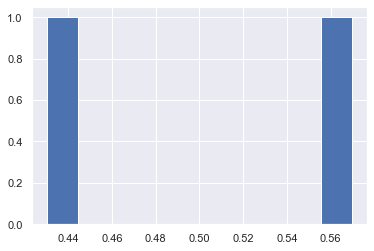

In [70]:
df.has_vehicle.value_counts(normalize = True).hist()

In [71]:
df.has_spouse.value_counts(normalize = True)

1    0.5696
0    0.4304
Name: has_spouse, dtype: float64

In [72]:
df['облачный день'].value_counts(normalize = True)

 1    0.923533
-1    0.038400
 0    0.038067
Name: облачный день, dtype: float64

In [85]:
df.describe()

,taxi,car,bike,pedestrian,ot,sex,has_vehicle,has_spouse,балл_пробок,дождь,снег,туман,мгла,гроза,метель,гололёд,изморозь,ветер,облачный день,температура
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,0.616440,0.681432,0.143642,0.216275,0.706735,0.498733,0.572100,0.572100,5.227267,0.431700,0.318133,0.023433,0.008467,0.065867,0.042033,0.015000,0.016633,4.550601,0.887700,5.860112
std,0.270016,0.325557,0.221165,0.240470,0.260247,0.500007,0.494783,0.494783,1.312253,0.495321,0.465759,0.151278,0.091626,0.248053,0.200669,0.121554,0.127895,5.076349,0.417805,12.574534
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-19.800000
25%,0.453231,0.479501,0.000000,0.000000,0.546948,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-3.202500
50%,0.650769,0.679677,0.000000,0.139207,0.708832,0.000000,1.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.020000,1.000000,5.900000
75%,0.834411,1.000000,0.209814,0.345668,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.750000,1.000000,14.860000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,34.000000,1.000000,34.300000


In [75]:
df.groupby('has_vehicle')[targets].mean()

,taxi,car,bike,pedestrian,ot
has_vehicle,,,,,
0,0.508849,0.385021,0.145802,0.290206,0.898471
1,0.670061,0.903676,0.139046,0.165140,0.563873


In [ ]:
df.columns

In [76]:
targets = ['taxi', 'car', 'bike', 'pedestrian', 'ot']

In [90]:
df.groupby('балл_пробок')[targets].mean().round(2)

,taxi,car,bike,pedestrian,ot
балл_пробок,,,,,
2,0.66,0.73,0.06,0.17,0.71
3,0.64,0.74,0.07,0.18,0.69
4,0.65,0.74,0.07,0.18,0.69
5,0.64,0.74,0.07,0.18,0.69
6,0.64,0.74,0.07,0.19,0.69
7,0.51,0.45,0.44,0.35,0.76
8,0.54,0.47,0.42,0.32,0.77


In [89]:
df.groupby('sex')[targets].mean().round(2)

,taxi,car,bike,pedestrian,ot
sex,,,,,
0,0.64,0.69,0.13,0.21,0.71
1,0.60,0.68,0.16,0.22,0.70


In [88]:
df.groupby('income')[targets].median().round(2)

,taxi,car,bike,pedestrian,ot
income,,,,,
high-middle,0.80,1.00,0.00,0.06,0.61
low-middle,0.55,0.56,0.06,0.28,0.87
middle,0.69,0.96,0.00,0.09,0.67
powerty,0.56,0.45,0.00,0.26,1.00
rich,0.86,1.00,0.00,0.00,0.56


<Figure size 1080x1440 with 0 Axes>

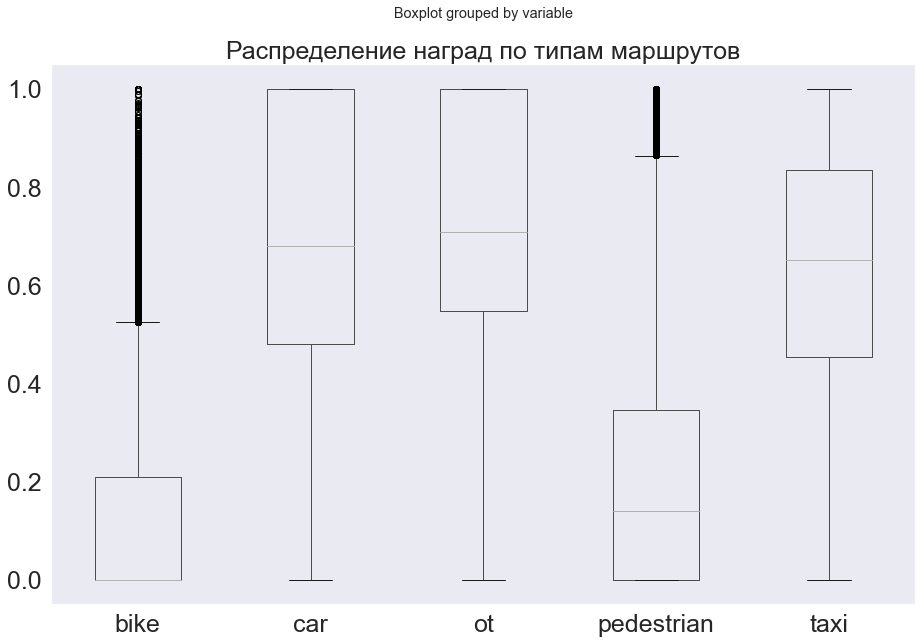

In [86]:
plt.figure(figsize=(15,20))
ax = pd.melt(df, value_vars=targets).boxplot(by='variable', fontsize =25, figsize=(15,10) ,grid=False)
x_axis = ax.axes.get_xaxis()
x_label = x_axis.get_label()
plt.title('Распределение наград по типам маршрутов', fontsize=25);
##print isinstance(x_label, matplotlib.artist.Artist)
x_label.set_visible(False);

In [ ]:
df.groupby(pd.cut(df['ветер'], 7))[targets].mean()

In [ ]:
df.groupby(pd.cut(df['температура'], 7))[targets].mean()

# Обработка данных

In [300]:
targets = ['taxi', 'car', 'bike', 'pedestrian', 'ot']

In [301]:
targets_df = df[targets]

In [302]:
df = df.drop(targets, axis=1)

In [303]:
numeric_data = df.select_dtypes([np.float64])
numeric_features = numeric_data.columns
cat_data = df.select_dtypes([np.object, np.int64])
cat_features = cat_data.columns

In [304]:
numeric_features

Index(['ветер', 'температура'], dtype='object')

In [96]:
cat_features

Index(['sex', 'age', 'has_vehicle', 'income', 'has_spouse', 'балл_пробок',
       'дождь', 'снег', 'туман', 'мгла', 'гроза', 'метель', 'гололёд',
       'изморозь', 'облачный день'],
      dtype='object')

In [305]:
def train_grid(model, params, X, y, random_grid=False, cv=5, scoring='neg_mean_squared_error', n_iter=100):
    if random_grid:
        grid = RandomizedSearchCV(model, params, n_iter=n_iter, n_jobs=-1, scoring=scoring, cv=cv)
    else:
        grid = GridSearchCV(model, params, cv=cv, scoring=scoring, n_jobs=-1)
    grid.fit(X, y)
    print('Model {}, score: {}, best_params: {}'.format(grid.estimator, grid.best_score_, grid.best_params_))
    return grid.best_estimator_

In [98]:
from sklearn.preprocessing import PolynomialFeatures

In [13]:
poly_features = ['sex', 'has_spouse', 'has_vehicle']

In [14]:
cat_features

Index(['sex', 'age', 'has_vehicle', 'income', 'has_spouse', 'балл_пробок',
       'дождь', 'снег', 'туман', 'мгла', 'гроза', 'метель', 'гололёд',
       'изморозь', 'облачный день'],
      dtype='object')

In [384]:
def calc_weight_for_route_type(df, route_type, test_size=0.3, sample= 0.8, degree = 2, interaction_only = False, include_poly_features = True, random_state=42):

    random_index = np.random.randint(df.index.start, df.index.stop, size=int(sample*len(df)))

    X_train, X_test, y_train, y_test = train_test_split(df.loc[random_index], targets_df.loc[random_index, route_type].values, 
                                                        test_size=test_size, random_state=random_state)

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(), cat_features),
            ('num', StandardScaler(), numeric_features)], n_jobs=-1)
    
    if include_poly_features:
        ridge_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                          ('poly', PolynomialFeatures(interaction_only = interaction_only, degree=degree, include_bias = True)),
                                          ('regressor', Ridge())])
        lasso_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                         ('poly', PolynomialFeatures(interaction_only = interaction_only, degree=degree, include_bias = True)),
                                         ('regressor', Lasso())])
        sgd_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                       ('poly', PolynomialFeatures(interaction_only = interaction_only, degree=degree, include_bias = True)),
                                       ('regressor', SGDRegressor())])
    else:
        ridge_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                          ('regressor', Ridge())])
        lasso_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                         ('regressor', Lasso())])
        sgd_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                       ('regressor', SGDRegressor())])
    
    ridge_params = {'regressor__alpha': 10.0 ** -np.arange(1, 6)}
    lasso_params = {'regressor__alpha': 10.0 ** -np.arange(4, 6)}
    sgd_params = {'regressor__penalty': ['l2', 'l1', 'elasticnet'], 'regressor__learning_rate': [ 'optimal', 'adaptive'], 'regressor__loss':  ['squared_loss', 'huber'], 'regressor__alpha': 10.0 ** -np.arange(4, 6)}

    models = [ridge_pipeline, lasso_pipeline, sgd_pipeline]
    params = [ridge_params, lasso_params, sgd_params]
    
    predictors = []
    for model, param in zip(models, params):
        predictors.append(train_grid(model, param, X_train, y_train))
    return predictors

In [529]:
def calc_weight_for_route_type_poly(df, route_type, test_size=0.3, sample= 0.8, degree = 2, random_state=42):

    random_index = np.random.randint(df.index.start, df.index.stop, size=int(sample*len(df)))

    X_train, X_test, y_train, y_test = train_test_split(df.loc[random_index], targets_df.loc[random_index, route_type].values, 
                                                        test_size=test_size, random_state=random_state)

                    
    cat_transformers = Pipeline(steps=[
        ('onehot', OneHotEncoder()),
        ('poly',  PolynomialFeatures(interaction_only = True, degree=degree, include_bias = True))])

    num_transformers = Pipeline(steps=[
        ('num', StandardScaler())])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num_tr', num_transformers, numeric_features),
            ('cat_tr', cat_transformers, cat_features)], n_jobs=-1)

        
    ridge_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                      ('regressor', Ridge())])
    lasso_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('regressor', Lasso())])
    sgd_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('regressor', SGDRegressor())])

    
    ridge_params = {'regressor__alpha': 10.0 ** -np.arange(1, 6)}
    lasso_params = {'regressor__alpha': 10.0 ** -np.arange(4, 6)}
    sgd_params = {'regressor__penalty': ['l2', 'l1', 'elasticnet'], 'regressor__learning_rate': [ 'optimal', 'adaptive'], 'regressor__loss':  ['squared_loss', 'huber'], 'regressor__alpha': 10.0 ** -np.arange(4, 6)}

    models = [ridge_pipeline, lasso_pipeline, sgd_pipeline]
    params = [ridge_params, lasso_params, sgd_params]
    
    predictors = []
    for model, param in zip(models, params):
        predictors.append(train_grid(model, param, X_train, y_train))
    return predictors

# Оценка весов признаков линейными алгоритмами

### С полиномиальными признаками

#### Только взаимодействия для категориальных признаковё

In [530]:
car_regr_poly_cat = calc_weight_for_route_type_poly(df, sample=.5, route_type = 'car')

Model Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_tr',
                                                  Pipeline(steps=[('num',
                                                                   StandardScaler())]),
                                                  Index(['ветер', 'температура'], dtype='object')),
                                                 ('cat_tr',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder()),
                                                                  ('poly',
                                                                   PolynomialFeatures(interaction_only=True))]),
                                                  Index(['sex', 'age', 'has_vehicle', 'income', 'has_spouse', 'балл_пробок',
       'дождь', 'снег', 'туман', 'мгла', 'гроза', 'метель'

/Users/sinvic/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.21464794724118974, tolerance: 0.11410462101640388
  model = cd_fast.sparse_enet_coordinate_descent(


Model Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_tr',
                                                  Pipeline(steps=[('num',
                                                                   StandardScaler())]),
                                                  Index(['ветер', 'температура'], dtype='object')),
                                                 ('cat_tr',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder()),
                                                                  ('poly',
                                                                   PolynomialFeatures(interaction_only=True))]),
                                                  Index(['sex', 'age', 'has_vehicle', 'income', 'has_spouse', 'балл_пробок',
       'дождь', 'снег', 'туман', 'мгла', 'гроза', 'метель'

In [531]:
ot_regr_poly_cat = calc_weight_for_route_type_poly(df, sample=.5, route_type = 'ot')

Model Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_tr',
                                                  Pipeline(steps=[('num',
                                                                   StandardScaler())]),
                                                  Index(['ветер', 'температура'], dtype='object')),
                                                 ('cat_tr',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder()),
                                                                  ('poly',
                                                                   PolynomialFeatures(interaction_only=True))]),
                                                  Index(['sex', 'age', 'has_vehicle', 'income', 'has_spouse', 'балл_пробок',
       'дождь', 'снег', 'туман', 'мгла', 'гроза', 'метель'

/Users/sinvic/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.35240245278527027, tolerance: 0.0711360311942329
  model = cd_fast.sparse_enet_coordinate_descent(


Model Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_tr',
                                                  Pipeline(steps=[('num',
                                                                   StandardScaler())]),
                                                  Index(['ветер', 'температура'], dtype='object')),
                                                 ('cat_tr',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder()),
                                                                  ('poly',
                                                                   PolynomialFeatures(interaction_only=True))]),
                                                  Index(['sex', 'age', 'has_vehicle', 'income', 'has_spouse', 'балл_пробок',
       'дождь', 'снег', 'туман', 'мгла', 'гроза', 'метель'

In [532]:
pedestrian_regr_poly_cat = calc_weight_for_route_type_poly(df, sample=.5, route_type = 'pedestrian')

Model Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_tr',
                                                  Pipeline(steps=[('num',
                                                                   StandardScaler())]),
                                                  Index(['ветер', 'температура'], dtype='object')),
                                                 ('cat_tr',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder()),
                                                                  ('poly',
                                                                   PolynomialFeatures(interaction_only=True))]),
                                                  Index(['sex', 'age', 'has_vehicle', 'income', 'has_spouse', 'балл_пробок',
       'дождь', 'снег', 'туман', 'мгла', 'гроза', 'метель'

In [533]:
bike_regr_poly_cat = calc_weight_for_route_type_poly(df, sample=.5, route_type = 'bike')

Model Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_tr',
                                                  Pipeline(steps=[('num',
                                                                   StandardScaler())]),
                                                  Index(['ветер', 'температура'], dtype='object')),
                                                 ('cat_tr',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder()),
                                                                  ('poly',
                                                                   PolynomialFeatures(interaction_only=True))]),
                                                  Index(['sex', 'age', 'has_vehicle', 'income', 'has_spouse', 'балл_пробок',
       'дождь', 'снег', 'туман', 'мгла', 'гроза', 'метель'

In [534]:
taxi_regr_poly_cat = calc_weight_for_route_type_poly(df, sample=.5, route_type = 'taxi')

Model Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_tr',
                                                  Pipeline(steps=[('num',
                                                                   StandardScaler())]),
                                                  Index(['ветер', 'температура'], dtype='object')),
                                                 ('cat_tr',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder()),
                                                                  ('poly',
                                                                   PolynomialFeatures(interaction_only=True))]),
                                                  Index(['sex', 'age', 'has_vehicle', 'income', 'has_spouse', 'балл_пробок',
       'дождь', 'снег', 'туман', 'мгла', 'гроза', 'метель'

/Users/sinvic/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.525832486836748, tolerance: 0.07893253441532644
  model = cd_fast.sparse_enet_coordinate_descent(


Model Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_tr',
                                                  Pipeline(steps=[('num',
                                                                   StandardScaler())]),
                                                  Index(['ветер', 'температура'], dtype='object')),
                                                 ('cat_tr',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder()),
                                                                  ('poly',
                                                                   PolynomialFeatures(interaction_only=True))]),
                                                  Index(['sex', 'age', 'has_vehicle', 'income', 'has_spouse', 'балл_пробок',
       'дождь', 'снег', 'туман', 'мгла', 'гроза', 'метель'

In [561]:
estimated_weights_cat_poly = np.vstack((taxi_regr_poly_cat[0]['regressor'].coef_,
                               car_regr_poly_cat[0]['regressor'].coef_,
                               bike_regr_poly_cat[0]['regressor'].coef_, 
                               pedestrian_regr_poly_cat[0]['regressor'].coef_,
                               ot_regr_poly_cat[0]['regressor'].coef_,
                              ))

In [545]:
ot_regr_poly_cat[2]['regressor'].coef_

array([ 0.03544996, -0.00922286,  0.12550387,  0.0191981 ,  0.00708161,
        0.        ,  0.        ,  0.00844604,  0.        ,  0.        ,
        0.06580329,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.06580329,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.02002452,  0.00625519,  0.        ,  0.03202254,
        0.01292272,  0.01335699,  0.01659516,  0.00968456,  0.01283234,
        0.01344737,  0.02217205,  0.00410766,  0.02114583,  0.00513388,
        0.01932835,  0.00695136,  0.        ,  0.        ,  0.        ,
        0.        ,  0.01351779,  0.00871052,  0.00161   ,  0.        ,
       -0.00638065,  0.        ,  0.        ,  0.        ,  0.        ,
        0.0046266 ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.00260591,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [547]:
ot_regr_poly_cat[2]['regressor'].coef_.shape

(906,)

In [541]:
cat_transformers = Pipeline(steps=[
        ('onehot', OneHotEncoder()),
        ('poly',  PolynomialFeatures(interaction_only = True, degree=2, include_bias = True))])

num_transformers = Pipeline(steps=[
    ('num', StandardScaler())])

preprocessor_cat_only = ColumnTransformer(
    transformers=[
        ('num_tr', num_transformers, numeric_features),
        ('cat_tr', cat_transformers, cat_features)], n_jobs=-1)
df_transformed_cat_only = preprocessor_cat_only.fit_transform(df)

In [542]:
df_transformed_cat_only.shape

(30000, 906)

In [554]:
df_transformed_cat_only.toarray()

array([[ 0.56420733, -0.29376767,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.82819616,  1.08171192,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.67573926,  0.07201746,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.05210868, -0.11047664,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.90063298, -0.66991272,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.44114486,  0.44975635,  1.        , ...,  0.        ,
         0.        ,  0.        ]])

##  LogReg

In [564]:
from sklearn.linear_model import LogisticRegressionCV

In [575]:
random_index = np.random.randint(0, len(df_transformed_cat_only.toarray()), size=int(0.5*len(df_transformed_cat_only.toarray())))

labels_df = np.where(targets_df.values <= 0.5, 0, 1)

In [586]:
labels_df = targets_df.values.argmax(1)

In [587]:
X_train, X_test, y_train, y_test = train_test_split(df_transformed_cat_only.toarray()[random_index], labels_df[random_index], 
                                                        test_size=0.1, random_state=125)

In [589]:
clf = LogisticRegressionCV(Cs = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2], penalty = 'l1', solver = 'saga', scoring = 'accuracy', multi_class = 'multinomial', cv=5, random_state=0).fit(X_train, y_train)

/Users/sinvic/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/sinvic/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/sinvic/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/sinvic/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/sinvic/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

In [595]:
weights_log = clf.predict_proba(df_transformed_cat_only.toarray()[~random_index])

In [598]:
weights_log.shape

(15000, 5)

In [603]:
 df_transformed_cat_only.toarray()[~random_index].shape

(15000, 906)

In [604]:
weights_log[:2000].shape

(2000, 5)

In [605]:
BANDITS = [LinUCB, RandomBandit, UCB1_Bandit, LinPRUCB]
env = ContextLinEnvironment(2000, BANDITS, n_action=5, n_dims = 906, 
                            context = df_transformed_cat_only.toarray()[~random_index][:2000], 
                            rewards = weights_log[:2000])

In [607]:
%%time
exp_lin_prucb_cat_only = Experiment.run(env, type_ = 'lin_prucb', alpha=0.1, beta =0.3, etha=0.7);

==================== STATS ====================
Type of the bandit: lin_prucb
Total reward: 174.51784442795702
Total regret: 1575.8750287524429
Accuracy: 0.0534999999999999
True success probabilities: None
Bandits pull count: [2000    0    0    0    0]
Estimates of success probability: [[[ 10.27651593]
  [-27.45069821]
  [151.1777065 ]
  ...
  [-23.34013819]
  [-23.340138  ]
  [-23.340138  ]]

 [[  0.        ]
  [  0.        ]
  [  0.        ]
  ...
  [  0.        ]
  [  0.        ]
  [  0.        ]]

 [[  0.        ]
  [  0.        ]
  [  0.        ]
  ...
  [  0.        ]
  [  0.        ]
  [  0.        ]]

 [[  0.        ]
  [  0.        ]
  [  0.        ]
  ...
  [  0.        ]
  [  0.        ]
  [  0.        ]]

 [[  0.        ]
  [  0.        ]
  [  0.        ]
  ...
  [  0.        ]
  [  0.        ]
  [  0.        ]]]
Reward from all bandit: [174.51784443   0.           0.           0.           0.        ]
CPU times: user 30min 32s, sys: 35 s, total: 31min 7s
Wall time: 16min 3

#### Только взаимодействия

In [385]:
car_regr_int_only = calc_weight_for_route_type(df, degree=1, interaction_only = True, sample=.5, route_type = 'car')

Model Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat', OneHotEncoder(),
                                                  Index(['sex', 'age', 'has_vehicle', 'income', 'has_spouse', 'балл_пробок',
       'дождь', 'снег', 'туман', 'мгла', 'гроза', 'метель', 'гололёд',
       'изморозь', 'облачный день'],
      dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['ветер', 'температура'], dtype='object'))])),
                ('poly', PolynomialFeatures(degree=1, interaction_only=True)),
                ('regressor', Ridge())]), score: -0.020666260087705383, best_params: {'regressor__alpha': 0.1}
Model Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat', OneHotEncoder(),
                                                  Index([

In [386]:
ot_regr_int_only = calc_weight_for_route_type(df,  degree=1, interaction_only = True, sample=1, route_type= 'ot')

Model Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat', OneHotEncoder(),
                                                  Index(['sex', 'age', 'has_vehicle', 'income', 'has_spouse', 'балл_пробок',
       'дождь', 'снег', 'туман', 'мгла', 'гроза', 'метель', 'гололёд',
       'изморозь', 'облачный день'],
      dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['ветер', 'температура'], dtype='object'))])),
                ('poly', PolynomialFeatures(degree=1, interaction_only=True)),
                ('regressor', Ridge())]), score: -0.026993090567741417, best_params: {'regressor__alpha': 0.1}
Model Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat', OneHotEncoder(),
                                                  Index([

In [387]:
pedestrian_regr_int_only = calc_weight_for_route_type(df,  degree=1, interaction_only = True, sample=1, route_type= 'pedestrian')

Model Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat', OneHotEncoder(),
                                                  Index(['sex', 'age', 'has_vehicle', 'income', 'has_spouse', 'балл_пробок',
       'дождь', 'снег', 'туман', 'мгла', 'гроза', 'метель', 'гололёд',
       'изморозь', 'облачный день'],
      dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['ветер', 'температура'], dtype='object'))])),
                ('poly', PolynomialFeatures(degree=1, interaction_only=True)),
                ('regressor', Ridge())]), score: -0.03386037582598796, best_params: {'regressor__alpha': 0.1}


/Users/sinvic/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.43477131067948, tolerance: 0.11988042093623527
  model = cd_fast.enet_coordinate_descent(


Model Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat', OneHotEncoder(),
                                                  Index(['sex', 'age', 'has_vehicle', 'income', 'has_spouse', 'балл_пробок',
       'дождь', 'снег', 'туман', 'мгла', 'гроза', 'метель', 'гололёд',
       'изморозь', 'облачный день'],
      dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['ветер', 'температура'], dtype='object'))])),
                ('poly', PolynomialFeatures(degree=1, interaction_only=True)),
                ('regressor', Lasso())]), score: -0.03386036400651994, best_params: {'regressor__alpha': 1e-05}
Model Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat', OneHotEncoder(),
                                                  Index(

In [388]:
bike_regr_int_only = calc_weight_for_route_type(df,  degree=1, interaction_only = True, sample=1, route_type= 'bike')

Model Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat', OneHotEncoder(),
                                                  Index(['sex', 'age', 'has_vehicle', 'income', 'has_spouse', 'балл_пробок',
       'дождь', 'снег', 'туман', 'мгла', 'гроза', 'метель', 'гололёд',
       'изморозь', 'облачный день'],
      dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['ветер', 'температура'], dtype='object'))])),
                ('poly', PolynomialFeatures(degree=1, interaction_only=True)),
                ('regressor', Ridge())]), score: -0.015906123934289022, best_params: {'regressor__alpha': 0.1}
Model Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat', OneHotEncoder(),
                                                  Index([

In [389]:
taxi_regr_int_only = calc_weight_for_route_type(df, degree=1, interaction_only = True, sample=1, route_type= 'taxi')

Model Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat', OneHotEncoder(),
                                                  Index(['sex', 'age', 'has_vehicle', 'income', 'has_spouse', 'балл_пробок',
       'дождь', 'снег', 'туман', 'мгла', 'гроза', 'метель', 'гололёд',
       'изморозь', 'облачный день'],
      dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['ветер', 'температура'], dtype='object'))])),
                ('poly', PolynomialFeatures(degree=1, interaction_only=True)),
                ('regressor', Ridge())]), score: -0.043321673595208235, best_params: {'regressor__alpha': 0.1}
Model Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat', OneHotEncoder(),
                                                  Index([

In [473]:
estimated_weights_int_only = np.vstack((taxi_regr_int_only[0]['regressor'].coef_,
                               car_regr_int_only[0]['regressor'].coef_,
                               bike_regr_int_only[0]['regressor'].coef_, 
                               pedestrian_regr_int_only[0]['regressor'].coef_,
                               ot_regr_int_only[0]['regressor'].coef_,
                              ))

In [407]:
taxi_regr_int_only[1]['regressor'].coef_

array([ 0.00000000e+00,  4.25118869e-02, -1.20963764e-17,  0.00000000e+00,
        2.59230636e-02,  4.06787944e-02, -5.47403974e-02, -1.12603813e-01,
       -7.88571798e-02,  0.00000000e+00,  7.52742973e-02, -1.00233664e-01,
        0.00000000e+00, -1.44415240e-01,  1.26065843e-01, -0.00000000e+00,
        0.00000000e+00,  1.62746947e-04, -1.14497555e-03,  7.47107719e-04,
        9.21637814e-04,  0.00000000e+00, -1.44686215e-01, -1.12699228e-01,
       -1.76068006e-01,  4.58171639e-15, -4.50026360e-02,  5.76077724e-16,
       -4.68888237e-02,  1.78943426e-15, -1.84310521e-02,  3.46883397e-16,
       -3.68968622e-02,  6.56257823e-16, -7.11680096e-02,  0.00000000e+00,
       -7.05009025e-02,  0.00000000e+00, -4.86196035e-02,  5.66923507e-16,
       -0.00000000e+00, -8.18372752e-03,  9.22767870e-02,  5.49570061e-02,
       -1.57862993e-02])

In [395]:
estimated_weights_int_only.shape

(5, 45)

#### + степени

In [372]:
car_regr = calc_weight_for_route_type(df, sample=.5, route_type = 'car')

Model Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat', OneHotEncoder(),
                                                  Index(['sex', 'age', 'has_vehicle', 'income', 'has_spouse', 'балл_пробок',
       'дождь', 'снег', 'туман', 'мгла', 'гроза', 'метель', 'гололёд',
       'изморозь', 'облачный день'],
      dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['ветер', 'температура'], dtype='object'))])),
                ('poly', PolynomialFeatures()), ('regressor', Ridge())]), score: -0.015419220578596326, best_params: {'regressor__alpha': 0.1}
Model Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat', OneHotEncoder(),
                                                  Index(['sex', 'age', 'has_vehicle', 'income', 'has_spo

In [373]:
ot_regr = calc_weight_for_route_type(df,  sample=1, route_type= 'ot')

Model Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat', OneHotEncoder(),
                                                  Index(['sex', 'age', 'has_vehicle', 'income', 'has_spouse', 'балл_пробок',
       'дождь', 'снег', 'туман', 'мгла', 'гроза', 'метель', 'гололёд',
       'изморозь', 'облачный день'],
      dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['ветер', 'температура'], dtype='object'))])),
                ('poly', PolynomialFeatures()), ('regressor', Ridge())]), score: -0.01803801692659007, best_params: {'regressor__alpha': 0.1}


/Users/sinvic/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3596560597955545, tolerance: 0.14441500706487684
  model = cd_fast.enet_coordinate_descent(


Model Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat', OneHotEncoder(),
                                                  Index(['sex', 'age', 'has_vehicle', 'income', 'has_spouse', 'балл_пробок',
       'дождь', 'снег', 'туман', 'мгла', 'гроза', 'метель', 'гололёд',
       'изморозь', 'облачный день'],
      dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['ветер', 'температура'], dtype='object'))])),
                ('poly', PolynomialFeatures()), ('regressor', Lasso())]), score: -0.017962159296888616, best_params: {'regressor__alpha': 0.0001}
Model Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat', OneHotEncoder(),
                                                  Index(['sex', 'age', 'has_vehicle', 'income', 'has_

In [374]:
pedestrian_regr = calc_weight_for_route_type(df,  sample=1, route_type= 'pedestrian')

Model Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat', OneHotEncoder(),
                                                  Index(['sex', 'age', 'has_vehicle', 'income', 'has_spouse', 'балл_пробок',
       'дождь', 'снег', 'туман', 'мгла', 'гроза', 'метель', 'гололёд',
       'изморозь', 'облачный день'],
      dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['ветер', 'температура'], dtype='object'))])),
                ('poly', PolynomialFeatures()), ('regressor', Ridge())]), score: -0.024309696774706974, best_params: {'regressor__alpha': 0.1}


/Users/sinvic/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2035317944383337, tolerance: 0.11842664946815026
  model = cd_fast.enet_coordinate_descent(


Model Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat', OneHotEncoder(),
                                                  Index(['sex', 'age', 'has_vehicle', 'income', 'has_spouse', 'балл_пробок',
       'дождь', 'снег', 'туман', 'мгла', 'гроза', 'метель', 'гололёд',
       'изморозь', 'облачный день'],
      dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['ветер', 'температура'], dtype='object'))])),
                ('poly', PolynomialFeatures()), ('regressor', Lasso())]), score: -0.02422188941480904, best_params: {'regressor__alpha': 0.0001}
Model Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat', OneHotEncoder(),
                                                  Index(['sex', 'age', 'has_vehicle', 'income', 'has_s

In [375]:
bike_regr = calc_weight_for_route_type(df,  sample=1, route_type= 'bike')

Model Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat', OneHotEncoder(),
                                                  Index(['sex', 'age', 'has_vehicle', 'income', 'has_spouse', 'балл_пробок',
       'дождь', 'снег', 'туман', 'мгла', 'гроза', 'метель', 'гололёд',
       'изморозь', 'облачный день'],
      dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['ветер', 'температура'], dtype='object'))])),
                ('poly', PolynomialFeatures()), ('regressor', Ridge())]), score: -0.011878387232050454, best_params: {'regressor__alpha': 0.1}
Model Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat', OneHotEncoder(),
                                                  Index(['sex', 'age', 'has_vehicle', 'income', 'has_spo

In [376]:
best_regressor_weights_taxi = calc_weight_for_route_type(df,  sample=1, route_type=  'taxi')

Model Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat', OneHotEncoder(),
                                                  Index(['sex', 'age', 'has_vehicle', 'income', 'has_spouse', 'балл_пробок',
       'дождь', 'снег', 'туман', 'мгла', 'гроза', 'метель', 'гололёд',
       'изморозь', 'облачный день'],
      dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['ветер', 'температура'], dtype='object'))])),
                ('poly', PolynomialFeatures()), ('regressor', Ridge())]), score: -0.03193277129895174, best_params: {'regressor__alpha': 0.1}
Model Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat', OneHotEncoder(),
                                                  Index(['sex', 'age', 'has_vehicle', 'income', 'has_spou

predictors[0]['preprocessor'].transformers_[0][1].get_feature_names(cat_features)

In [ ]:
best_regressor_weights.shape

In [255]:
car_regr[1]['regressor'].coef_[ot_regr[1]['regressor'].coef_ > 0]

array([-2.24620637e-01, -3.60113859e-03, -0.00000000e+00,  1.12116854e-03,
        0.00000000e+00, -2.36722887e-03,  0.00000000e+00, -7.82212238e-04,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  3.68320694e-04, -4.88942988e-02,
        1.27357078e-02, -4.72836472e-04, -2.34437282e-02,  1.99731390e-03,
        1.95751082e-03,  0.00000000e+00,  0.00000000e+00,  3.21908944e-03,
        0.00000000e+00,  1.59301014e-03,  3.25918848e-03,  3.13073256e-03,
       -0.00000000e+00,  2.77785852e-02, -0.00000000e+00,  0.00000000e+00,
       -1.98347490e-02,  3.03606845e-02, -1.17096309e-02, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.01844633e-01,
       -3.33899511e-03, -1.77824350e-03,  3.70610485e-03, -3.39637258e-03,
        0.00000000e+00, -1.51474029e-01,  0.00000000e+00, -0.00000000e+00,
       -3.25394078e-02, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -9.03954270e-02, -

In [377]:
estimated_weights = np.vstack((best_regressor_weights_taxi[2]['regressor'].coef_,
                               car_regr[2]['regressor'].coef_,
                               bike_regr[2]['regressor'].coef_, 
                               pedestrian_regr[2]['regressor'].coef_,
                               ot_regr[2]['regressor'].coef_,
                              ))

In [286]:
estimated_weights.shape

(5, 1035)

In [287]:
from collections import Counter

In [418]:
Counter((df_transformed_with_polinomial[:30000] @ estimated_weights.T).argmax(1))

Counter({4: 14457, 1: 14828, 2: 588, 0: 92, 3: 35})

In [419]:
Counter((df_transformed[:5000] @ estimated_weights_wo_poly.T).argmax(1))

Counter({1: 2163, 0: 2779, 4: 39, 2: 8, 3: 11})

In [420]:
Counter((df_transformed_with_polinomial_int_only[:5000] @ estimated_weights_int_only.T).argmax(1))

Counter({3: 4705, 2: 226, 4: 65, 0: 4})

In [32]:
estimated_weights.shape

(5, 1035)

In [196]:
preprocessor_scaler = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(), cat_features),
            ('num', StandardScaler(), numeric_features)])
df_transformed = preprocessor_scaler.fit_transform(df)

In [397]:
poly_int_only = PolynomialFeatures(degree=1, interaction_only=True, include_bias = True) 
df_transformed_with_polinomial_int_only = poly_int_only.fit_transform(df_transformed)

In [ ]:
poly = PolynomialFeatures(degree=1, include_bias = True) 
df_transformed_with_polinomial = poly.fit_transform(df_transformed)

### Без полиномиальных признаков

In [307]:
car_regr_wo_poly = calc_weight_for_route_type(df, 'car',  sample=1, include_poly_features = False)

Model Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat', OneHotEncoder(),
                                                  Index(['sex', 'age', 'has_vehicle', 'income', 'has_spouse', 'балл_пробок',
       'дождь', 'снег', 'туман', 'мгла', 'гроза', 'метель', 'гололёд',
       'изморозь', 'облачный день'],
      dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['ветер', 'температура'], dtype='object'))])),
                ('regressor', Ridge())]), score: -0.02151255434615761, best_params: {'regressor__alpha': 0.1}
Model Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat', OneHotEncoder(),
                                                  Index(['sex', 'age', 'has_vehicle', 'income', 'has_spouse', 'балл_пробок',
       'дожд

In [308]:
ot_regr_wo_poly = calc_weight_for_route_type(df, 'ot', sample=1, include_poly_features = False)

Model Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat', OneHotEncoder(),
                                                  Index(['sex', 'age', 'has_vehicle', 'income', 'has_spouse', 'балл_пробок',
       'дождь', 'снег', 'туман', 'мгла', 'гроза', 'метель', 'гололёд',
       'изморозь', 'облачный день'],
      dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['ветер', 'температура'], dtype='object'))])),
                ('regressor', Ridge())]), score: -0.027393796647331502, best_params: {'regressor__alpha': 0.1}
Model Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat', OneHotEncoder(),
                                                  Index(['sex', 'age', 'has_vehicle', 'income', 'has_spouse', 'балл_пробок',
       'дож

In [309]:
bike_regr_wo_poly = calc_weight_for_route_type(df, 'bike',  sample=1, include_poly_features = False)

Model Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat', OneHotEncoder(),
                                                  Index(['sex', 'age', 'has_vehicle', 'income', 'has_spouse', 'балл_пробок',
       'дождь', 'снег', 'туман', 'мгла', 'гроза', 'метель', 'гололёд',
       'изморозь', 'облачный день'],
      dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['ветер', 'температура'], dtype='object'))])),
                ('regressor', Ridge())]), score: -0.015965220680661037, best_params: {'regressor__alpha': 0.1}
Model Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat', OneHotEncoder(),
                                                  Index(['sex', 'age', 'has_vehicle', 'income', 'has_spouse', 'балл_пробок',
       'дож

In [310]:
pedestrian_regr_wo_poly = calc_weight_for_route_type(df, 'pedestrian', sample=1, include_poly_features = False)

Model Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat', OneHotEncoder(),
                                                  Index(['sex', 'age', 'has_vehicle', 'income', 'has_spouse', 'балл_пробок',
       'дождь', 'снег', 'туман', 'мгла', 'гроза', 'метель', 'гололёд',
       'изморозь', 'облачный день'],
      dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['ветер', 'температура'], dtype='object'))])),
                ('regressor', Ridge())]), score: -0.03271119867336863, best_params: {'regressor__alpha': 0.1}


/Users/sinvic/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8805823666643846, tolerance: 0.11543647219524396
  model = cd_fast.enet_coordinate_descent(


Model Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat', OneHotEncoder(),
                                                  Index(['sex', 'age', 'has_vehicle', 'income', 'has_spouse', 'балл_пробок',
       'дождь', 'снег', 'туман', 'мгла', 'гроза', 'метель', 'гололёд',
       'изморозь', 'облачный день'],
      dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['ветер', 'температура'], dtype='object'))])),
                ('regressor', Lasso())]), score: -0.03271131048011446, best_params: {'regressor__alpha': 1e-05}
Model Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat', OneHotEncoder(),
                                                  Index(['sex', 'age', 'has_vehicle', 'income', 'has_spouse', 'балл_пробок',
       'до

In [311]:
taxi_regr_wo_poly = calc_weight_for_route_type(df, 'taxi',  sample=1, include_poly_features = False)

Model Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat', OneHotEncoder(),
                                                  Index(['sex', 'age', 'has_vehicle', 'income', 'has_spouse', 'балл_пробок',
       'дождь', 'снег', 'туман', 'мгла', 'гроза', 'метель', 'гололёд',
       'изморозь', 'облачный день'],
      dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['ветер', 'температура'], dtype='object'))])),
                ('regressor', Ridge())]), score: -0.04266546909825315, best_params: {'regressor__alpha': 0.1}


/Users/sinvic/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.222372297748393, tolerance: 0.1571713907572682
  model = cd_fast.enet_coordinate_descent(


Model Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat', OneHotEncoder(),
                                                  Index(['sex', 'age', 'has_vehicle', 'income', 'has_spouse', 'балл_пробок',
       'дождь', 'снег', 'туман', 'мгла', 'гроза', 'метель', 'гололёд',
       'изморозь', 'облачный день'],
      dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['ветер', 'температура'], dtype='object'))])),
                ('regressor', Lasso())]), score: -0.042665192138510735, best_params: {'regressor__alpha': 1e-05}
Model Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat', OneHotEncoder(),
                                                  Index(['sex', 'age', 'has_vehicle', 'income', 'has_spouse', 'балл_пробок',
       'д

In [339]:
estimated_weights_wo_poly = np.vstack((car_regr_wo_poly[2]['regressor'].coef_, 
          ot_regr_wo_poly[2]['regressor'].coef_,
          bike_regr_wo_poly[2]['regressor'].coef_,
          pedestrian_regr_wo_poly[2]['regressor'].coef_,
          taxi_regr_wo_poly[2]['regressor'].coef_,))

In [396]:
estimated_weights_wo_poly.shape

(5, 44)

In [314]:
car_regr_wo_poly[0]['regressor'].coef_

array([ 0.00094524, -0.00094524,  0.00683833,  0.02139666,  0.01658529,
       -0.00148063, -0.04333965, -0.13358469,  0.13358469,  0.01871185,
        0.00244024,  0.00701066, -0.00933661, -0.01882615, -0.13358469,
        0.13358469,  0.08052298,  0.0798434 ,  0.08484117,  0.08464296,
        0.08386415, -0.21345883, -0.20025585, -0.03662428,  0.03662428,
       -0.00969959,  0.00969959, -0.01498765,  0.01498765, -0.00272506,
        0.00272506, -0.00797142,  0.00797142, -0.01858091,  0.01858091,
       -0.01421766,  0.01421766, -0.01457921,  0.01457921, -0.01124499,
       -0.01153028,  0.02277527,  0.03341155, -0.01186178])

## GridSearch Polinomial

In [ ]:
BANDITS = [LinUCB, RandomBandit, UCB1_Bandit, LinPRUCB]

In [ ]:
grid_search_context({'alpha': np.arange(0.1, 1.5, 0.5),
                    'beta': np.arange(0.1, 1.5, 0.5),
                    'etha': np.arange(0.8, 0.95, 0.05)}, run_number = 3, n_action=5, n_dims = 1035, 
                    type_= 'lin_prucb', n_iter=2000, generate_stats=False, 
                    context = df_transformed_with_polinomial[:2000], rewards = targets_df.values[:2000])

In [ ]:
grid_search_context({'alpha': np.arange(0.1, 1.5, 0.5)}, run_number = 3, 
                    type_= 'ucb1', n_iter=2000, generate_stats=False, 
                    context = df_transformed_with_polinomial[:2000], rewards = targets_df.values[:2000])

In [ ]:
grid_search_context({'alpha': np.arange(0.1, 1.5, 0.2)}, run_number = 3, n_action=5, n_dims = 1035,
                    type_= 'lin_ucb', n_iter=2000, generate_stats=False,
                    context = df_transformed_with_polinomial[:2000], rewards = targets_df.values[:2000])

## GridSearch W/O Polinomial

In [365]:
nums_to_choose_hyperparam = 1000

In [360]:
grid_search_context({'alpha': np.arange(0.1, 1.5, 0.2),
                    'beta': np.arange(0.1, 1.5, 0.2),
                    'etha': np.arange(0.7, 0.95, 0.05)}, run_number = 3, 
                    type_= 'lin_prucb', n_iter=nums_to_choose_hyperparam, generate_stats=False, n_action=5, n_dims = 44,
                    context = df_transformed[:nums_to_choose_hyperparam], thetas = estimated_weights_wo_poly)

245it [04:31,  1.11s/it]


((('alpha', 0.1), ('beta', 0.30000000000000004), ('etha', 0.7)),
 {(('alpha', 0.1), ('beta', 0.1), ('etha', 0.7)): 0.4915225325419292,
  (('alpha', 0.1), ('beta', 0.1), ('etha', 0.75)): 0.4915225325419292,
  (('alpha', 0.1), ('beta', 0.1), ('etha', 0.8)): 0.4915225325419292,
  (('alpha', 0.1),
   ('beta', 0.1),
   ('etha', 0.8500000000000001)): 0.4915225325419292,
  (('alpha', 0.1),
   ('beta', 0.1),
   ('etha', 0.9000000000000001)): 0.4915225325419292,
  (('alpha', 0.1),
   ('beta', 0.30000000000000004),
   ('etha', 0.7)): 0.5298895193870438,
  (('alpha', 0.1),
   ('beta', 0.30000000000000004),
   ('etha', 0.75)): 0.5298895193870438,
  (('alpha', 0.1),
   ('beta', 0.30000000000000004),
   ('etha', 0.8)): 0.5298895193870438,
  (('alpha', 0.1),
   ('beta', 0.30000000000000004),
   ('etha', 0.8500000000000001)): 0.5298895193870438,
  (('alpha', 0.1),
   ('beta', 0.30000000000000004),
   ('etha', 0.9000000000000001)): 0.5298895193870438,
  (('alpha', 0.1),
   ('beta', 0.5000000000000001),

In [356]:
grid_search_context({'alpha': np.arange(0.1, 1.5, 0.1)}, run_number = 3, 
                    type_= 'ucb1', n_iter=nums_to_choose_hyperparam, generate_stats=False, 
                    context = df_transformed[:nums_to_choose_hyperparam], thetas = estimated_weights_wo_poly)

14it [00:00, 21.13it/s]


((('alpha', 0.1),),
 {(('alpha', 0.1),): 0.32423203393485944,
  (('alpha', 0.2),): 0.32423203393485944,
  (('alpha', 0.30000000000000004),): 0.32423203393485944,
  (('alpha', 0.4),): 0.32423203393485944,
  (('alpha', 0.5),): 0.32423203393485944,
  (('alpha', 0.6),): 0.32423203393485944,
  (('alpha', 0.7000000000000001),): 0.32423203393485944,
  (('alpha', 0.8),): 0.32423203393485944,
  (('alpha', 0.9),): 0.32423203393485944,
  (('alpha', 1.0),): 0.32423203393485944,
  (('alpha', 1.1),): 0.32423203393485944,
  (('alpha', 1.2000000000000002),): 0.32423203393485944,
  (('alpha', 1.3000000000000003),): 0.32423203393485944,
  (('alpha', 1.4000000000000001),): 0.32423203393485944})

In [359]:
grid_search_context({'alpha': np.arange(0.1, 1.5, 0.1)}, run_number = 3, 
                    type_= 'lin_ucb', n_iter=nums_to_choose_hyperparam, generate_stats=False, n_action=5, n_dims = 44, 
                    context = df_transformed[:nums_to_choose_hyperparam], thetas = estimated_weights_wo_poly)

14it [00:09,  1.42it/s]


((('alpha', 0.1),),
 {(('alpha', 0.1),): 0.5424884876964682,
  (('alpha', 0.2),): 0.5424884876964682,
  (('alpha', 0.30000000000000004),): 0.5424884876964682,
  (('alpha', 0.4),): 0.5424884876964682,
  (('alpha', 0.5),): 0.5424884876964682,
  (('alpha', 0.6),): 0.5424884876964682,
  (('alpha', 0.7000000000000001),): 0.5424884876964682,
  (('alpha', 0.8),): 0.5424884876964682,
  (('alpha', 0.9),): 0.5424884876964682,
  (('alpha', 1.0),): 0.5424884876964682,
  (('alpha', 1.1),): 0.5424884876964682,
  (('alpha', 1.2000000000000002),): 0.5424884876964682,
  (('alpha', 1.3000000000000003),): 0.5424884876964682,
  (('alpha', 1.4000000000000001),): 0.5424884876964682})

# Эксперименты с алгоритмами многоруких бандитов

### C полиномами 

In [371]:
BANDITS = [LinUCB, RandomBandit, UCB1_Bandit, LinPRUCB]
env = ContextLinEnvironment(2000, BANDITS, n_action=5, n_dims = 1035, context = df_transformed_with_polinomial[nums_to_choose_hyperparam:nums_to_choose_hyperparam + 2000], thetas = estimated_weights)

In [378]:
#  alpha = 1.5, beta = 1.5, etha = 0.9
exp_lin_prucb_with_polinomial = Experiment.run(env, type_ = 'lin_prucb', alpha=0.1, beta =0.3, etha=0.7);

==================== STATS ====================
Type of the bandit: lin_prucb
Total reward: 327.57249640231254
Total regret: 259.0159685905873
Accuracy: 0.41850000000000026
True success probabilities: [[ 0.          0.00425316 -0.00425316 ...  0.00489676  0.00773067
   0.07427711]
 [ 0.         -0.00055656  0.00055656 ...  0.00717382 -0.00044826
   0.04460082]
 [ 0.         -0.00367254  0.00367254 ... -0.00940059 -0.00649664
  -0.04202019]
 [ 0.         -0.0016364   0.0016364  ... -0.00356438 -0.00770169
  -0.05516258]
 [ 0.          0.00225586 -0.00225586 ...  0.00089373  0.00368823
   0.04360712]]
Bandits pull count: [   3    7    1 1989    0]
Estimates of success probability: [[[-3.04414892e+00]
  [-2.34974514e+00]
  [-2.38836627e-01]
  ...
  [-1.28003020e+00]
  [ 1.14217364e+00]
  [-1.33238064e+00]]

 [[-2.36786417e+00]
  [-1.95125354e+00]
  [-7.13476842e-02]
  ...
  [-3.13281393e-01]
  [ 1.46334579e+00]
  [-2.34824029e-01]]

 [[-3.10854770e+00]
  [-2.61495529e+00]
  [-1.68355478e-

In [379]:
%%time
exp_ucb_with_polinomial = Experiment.run(env, type_ = 'ucb1', alpha = 0.1);

==================== STATS ====================
Type of the bandit: ucb1
Total reward: 197.69315347035842
Total regret: 388.8953115225418
Accuracy: 0.33466933867735477
Bandits pull count: [ 188  183  150 1393   86]
Reward from all bandit: [ -3.47723958  -4.26284549  -7.94878762 226.85907965 -13.47705349]
Reward estimate all bandit: [-0.01839809 -0.02316764 -0.05264098  0.16273966 -0.15490866]
CPU times: user 151 ms, sys: 4.06 ms, total: 155 ms
Wall time: 93.6 ms


In [380]:
%%time
exp_lin_ucb_with_polinomial = Experiment.run(env, type_ = 'lin_ucb', alpha=0.1);

==================== STATS ====================
Type of the bandit: lin_ucb
Total reward: 327.57249640231254
Total regret: 259.0159685905873
Accuracy: 0.41850000000000026
True success probabilities: [[ 0.          0.00425316 -0.00425316 ...  0.00489676  0.00773067
   0.07427711]
 [ 0.         -0.00055656  0.00055656 ...  0.00717382 -0.00044826
   0.04460082]
 [ 0.         -0.00367254  0.00367254 ... -0.00940059 -0.00649664
  -0.04202019]
 [ 0.         -0.0016364   0.0016364  ... -0.00356438 -0.00770169
  -0.05516258]
 [ 0.          0.00225586 -0.00225586 ...  0.00089373  0.00368823
   0.04360712]]
Bandits pull count: [   3    7    1 1989    0]
Estimates of success probability: [[[-3.07941631e-03]
  [ 1.11588708e-03]
  [-3.79869092e-03]
  ...
  [-3.06678354e-05]
  [ 3.15581756e-04]
  [ 4.97815978e-04]]

 [[ 2.20753494e-03]
  [ 1.88621811e-03]
  [-5.98476018e-05]
  ...
  [ 4.02901733e-03]
  [ 1.40360010e-03]
  [ 4.68058533e-03]]

 [[-2.74265312e-03]
  [-2.74265312e-03]
  [ 5.20228745e-04

In [381]:
%%time
exp_random_with_polinomial = Experiment.run(env, type_ = 'random');

==================== STATS ====================
Type of the bandit: random
Total reward: -23.695987059830493
Total regret: 610.2844520527298
Accuracy: 0.19240379810094954
Bandits pull count: [403 362 397 399 439]
Reward from all bandit: [ -1.19006518  -3.49333696 -17.12765886  61.62704566 -63.51197172]
Reward estimate all bandit: [-0.00294571 -0.00962352 -0.04303432  0.15406761 -0.14434539]
CPU times: user 99.5 ms, sys: 10.1 ms, total: 110 ms
Wall time: 68 ms


## Полиномы только для категориальных признаков

In [562]:
nums_to_test = 5000
BANDITS = [LinUCB, RandomBandit, UCB1_Bandit, LinPRUCB]
env = ContextLinEnvironment(nums_to_test, BANDITS, n_action=5, n_dims = df_transformed_cat_only.shape[1], context = df_transformed_cat_only.toarray()[nums_to_choose_hyperparam:nums_to_choose_hyperparam + nums_to_test], thetas = estimated_weights_cat_poly)

In [563]:

exp_lin_prucb_cat_only = Experiment.run(env, type_ = 'lin_prucb', alpha=0.1, beta =0.3, etha=0.7);

==================== STATS ====================
Type of the bandit: lin_prucb
Total reward: 279.47092112760265
Total regret: 988.6798268675838
Accuracy: 0.39760000000000073
True success probabilities: [[ 5.90088570e-02 -1.49712287e-02 -2.46548194e-14 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 3.54784284e-02 -1.07421172e-02 -3.25200188e-14 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-3.19187117e-02  1.49945933e-02 -8.06097648e-14 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-4.83495940e-02  1.67380525e-02 -1.15471157e-13 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 3.55842003e-02 -9.54093646e-03  3.00483559e-14 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
Bandits pull count: [  25    1 2090    1 2883]
Estimates of success probability: [[[  4.68614323]
  [ -0.64416242]
  [ -2.92035222]
  ...
  [  0.44613092]
  [  0.44613092]
  [  0.44613092]]

 [[  2.36446955]
  [  1.11638785]
  [ -3.1670299 ]
  ...
  [  0.4849666 ]
  [  0.4

In [557]:
exp_lin_ucb_cat_only = Experiment.run(env, type_ = 'lin_ucb', alpha=0.1);

==================== STATS ====================
Type of the bandit: lin_ucb
Total reward: 2936.2138555173633
Total regret: 1658.7436175183518
Accuracy: 0.027400000000000025
True success probabilities: [[ 0.05878252 -0.01493844  0.11407362 ...  0.          0.
   0.        ]
 [ 0.03527802 -0.01085129  0.11040502 ...  0.          0.
   0.        ]
 [-0.03159572  0.01452424  0.         ...  0.          0.
   0.        ]
 [-0.0475917   0.01664818  0.         ...  0.          0.
   0.        ]
 [ 0.03544996 -0.00922286  0.12550387 ...  0.          0.
   0.        ]]
Bandits pull count: [5000    0    0    0    0]
Estimates of success probability: [[[-0.00022477]
  [-0.0011147 ]
  [ 0.00648039]
  ...
  [-0.00099973]
  [-0.00099973]
  [-0.00099973]]

 [[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  ...
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]]

 [[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  ...
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]]

 [[ 0.        ]
  [ 0.        ]
  [ 0.  

In [558]:
exp_ucb_int_cat_only = Experiment.run(env, type_ = 'ucb1', alpha=0.1);

==================== STATS ====================
Type of the bandit: ucb1
Total reward: 3401.637357980026
Total regret: 1193.32011505569
Accuracy: 0.42313851080864673
Bandits pull count: [ 485 1134   37   51 3293]
Reward from all bandit: [ 289.89527917  750.64876668    3.97402423   10.74183119 2346.37745671]
Reward estimate all bandit: [0.59649234 0.66136455 0.10457959 0.20657368 0.7123186 ]


In [559]:
exp_random_cat_only = Experiment.run(env, type_ = 'random', alpha=0.1);

==================== STATS ====================
Type of the bandit: random
Total reward: 2282.3890612867635
Total regret: 2312.5684117489423
Accuracy: 0.195160967806439
Bandits pull count: [ 968  970 1035  974 1053]
Reward from all bandit: [557.87144889 643.16623945 125.27388618 200.1177207  755.95976607]
Reward estimate all bandit: [0.57571873 0.66237512 0.12092074 0.20524894 0.71722938]


## Только взаимодействия

In [398]:
estimated_weights_int_only.shape

(5, 45)

In [399]:
df_transformed_with_polinomial_int_only.shape[1]

45

In [474]:
nums_to_test = 5000
BANDITS = [LinUCB, RandomBandit, UCB1_Bandit, LinPRUCB]
env = ContextLinEnvironment(nums_to_test, BANDITS, n_action=5, n_dims = df_transformed_with_polinomial_int_only.shape[1], context = df_transformed_with_polinomial_int_only[nums_to_choose_hyperparam:nums_to_choose_hyperparam+nums_to_test], thetas = estimated_weights_int_only)

In [479]:
%%time
exp_lin_prucb_int_only = Experiment.run(env, type_ = 'lin_prucb', alpha=0.1, beta =0.3, etha=0.7);

==================== STATS ====================
Type of the bandit: lin_prucb
Total reward: 450.8558967050891
Total regret: 868.7422357851224
Accuracy: 0.24540000000000056
True success probabilities: [[ 0.          0.0214787  -0.0214787   0.02043647  0.04677647  0.06111707
  -0.03521943 -0.09311058 -0.01965845  0.01965845  0.08413963 -0.09228417
   0.00844728 -0.13708259  0.13677985 -0.01965845  0.01965845  0.05088425
   0.03468717  0.03799021  0.0380494   0.03675668 -0.10845455 -0.08991316
  -0.0883091   0.0883091  -0.02267527  0.02267527 -0.02578883  0.02578883
  -0.01502827  0.01502827 -0.01947355  0.01947355 -0.0368061   0.0368061
  -0.03835769  0.03835769 -0.02688454  0.02688454 -0.02719502 -0.03787797
   0.065073    0.05506234 -0.01584778]
 [ 0.          0.00092489 -0.00092489  0.0068113   0.02554304  0.01828015
   0.00325503 -0.05388952 -0.13320743  0.13320743  0.01653047 -0.00399311
   0.00567398 -0.00809166 -0.01011969 -0.13320743  0.13320743  0.10847543
   0.07525326  0.08749

In [476]:
%%time
exp_lin_ucb_int_only = Experiment.run(env, type_ = 'lin_ucb', alpha=0.1);

==================== STATS ====================
Type of the bandit: lin_ucb
Total reward: 451.47369235617384
Total regret: 868.1244401340375
Accuracy: 0.24579999999999969
True success probabilities: [[ 0.          0.0214787  -0.0214787   0.02043647  0.04677647  0.06111707
  -0.03521943 -0.09311058 -0.01965845  0.01965845  0.08413963 -0.09228417
   0.00844728 -0.13708259  0.13677985 -0.01965845  0.01965845  0.05088425
   0.03468717  0.03799021  0.0380494   0.03675668 -0.10845455 -0.08991316
  -0.0883091   0.0883091  -0.02267527  0.02267527 -0.02578883  0.02578883
  -0.01502827  0.01502827 -0.01947355  0.01947355 -0.0368061   0.0368061
  -0.03835769  0.03835769 -0.02688454  0.02688454 -0.02719502 -0.03787797
   0.065073    0.05506234 -0.01584778]
 [ 0.          0.00092489 -0.00092489  0.0068113   0.02554304  0.01828015
   0.00325503 -0.05388952 -0.13320743  0.13320743  0.01653047 -0.00399311
   0.00567398 -0.00809166 -0.01011969 -0.13320743  0.13320743  0.10847543
   0.07525326  0.087494

In [477]:
%%time
exp_ucb_int_only = Experiment.run(env, type_ = 'ucb1', alpha=0.1);

==================== STATS ====================
Type of the bandit: ucb1
Total reward: 260.9615680045703
Total regret: 1058.6365644856412
Accuracy: 0.23258606885508457
Bandits pull count: [ 250  535 1100 2843  272]
Reward from all bandit: [-23.04491899  -5.02090478  49.3410378  261.97752434 -22.29117036]
Reward estimate all bandit: [-0.09181243 -0.00936736  0.04481475  0.09211587 -0.08165264]
CPU times: user 276 ms, sys: 6.4 ms, total: 282 ms
Wall time: 482 ms


In [478]:
%%time
exp_random_int_only = Experiment.run(env, type_ = 'random', alpha=0.1);

==================== STATS ====================
Type of the bandit: random
Total reward: -81.65905247788473
Total regret: 1401.2571849680946
Accuracy: 0.1955608878224358
Bandits pull count: [1005  938 1018 1006 1033]
Reward from all bandit: [ -89.47448661  -22.09803909   43.32624192  101.2784858  -114.6912545 ]
Reward estimate all bandit: [-0.08894084 -0.02353359  0.04251839  0.10057446 -0.11091998]
CPU times: user 145 ms, sys: 5.44 ms, total: 151 ms
Wall time: 250 ms


## без полиномов

In [443]:
nums_to_test = 5000
BANDITS = [LinUCB, RandomBandit, UCB1_Bandit, LinPRUCB]
env = ContextLinEnvironment(nums_to_test, BANDITS, n_action=5, n_dims = 44, context = df_transformed[nums_to_choose_hyperparam:nums_to_choose_hyperparam+nums_to_test], thetas = estimated_weights_wo_poly)

In [444]:
%%time
exp_lin_prucb = Experiment.run(env, type_ = 'lin_prucb', alpha=0.1, beta =0.3, etha=0.7);

==================== STATS ====================
Type of the bandit: lin_prucb
Total reward: 2923.9258970461533
Total regret: 1128.5731017909861
Accuracy: 0.5293999999999983
True success probabilities: [[ 4.55242743e-02  4.37579551e-02  2.46702764e-02  3.90255040e-02
   3.45043757e-02  1.63780129e-02 -2.52959397e-02 -8.89687660e-02
   1.78250995e-01  3.66399617e-02  2.06402379e-02  2.48920402e-02
   8.26153019e-03 -1.15154066e-03 -8.89687660e-02  1.78250995e-01
   9.31904098e-02  9.21304219e-02  9.78192564e-02  9.72216617e-02
   9.66039212e-02 -2.00840270e-01 -1.86843172e-01  7.98945822e-03
   8.12927711e-02  3.50093565e-02  5.42728729e-02  2.95906381e-02
   5.96915912e-02  4.13874664e-02  4.78947629e-02  3.66056849e-02
   5.26765444e-02  2.59941788e-02  6.32880505e-02  3.04694712e-02
   5.88127581e-02  3.05011658e-02  5.87810635e-02  1.83273630e-02
   1.86484870e-02  5.23063794e-02  3.33780481e-02 -1.19576700e-02]
 [ 6.08650719e-02  4.72845663e-02  9.32366460e-02  9.39155118e-02
   9.2

In [445]:
%%time
exp_lin_ucb = Experiment.run(env, type_ = 'lin_ucb', alpha=0.1);

==================== STATS ====================
Type of the bandit: lin_ucb
Total reward: 2923.9258970461533
Total regret: 1128.5731017909861
Accuracy: 0.5293999999999983
True success probabilities: [[ 4.55242743e-02  4.37579551e-02  2.46702764e-02  3.90255040e-02
   3.45043757e-02  1.63780129e-02 -2.52959397e-02 -8.89687660e-02
   1.78250995e-01  3.66399617e-02  2.06402379e-02  2.48920402e-02
   8.26153019e-03 -1.15154066e-03 -8.89687660e-02  1.78250995e-01
   9.31904098e-02  9.21304219e-02  9.78192564e-02  9.72216617e-02
   9.66039212e-02 -2.00840270e-01 -1.86843172e-01  7.98945822e-03
   8.12927711e-02  3.50093565e-02  5.42728729e-02  2.95906381e-02
   5.96915912e-02  4.13874664e-02  4.78947629e-02  3.66056849e-02
   5.26765444e-02  2.59941788e-02  6.32880505e-02  3.04694712e-02
   5.88127581e-02  3.05011658e-02  5.87810635e-02  1.83273630e-02
   1.86484870e-02  5.23063794e-02  3.33780481e-02 -1.19576700e-02]
 [ 6.08650719e-02  4.72845663e-02  9.32366460e-02  9.39155118e-02
   9.206

In [446]:
%%time
exp_ucb = Experiment.run(env, type_ = 'ucb1', alpha=0.1);

==================== STATS ====================
Type of the bandit: ucb1
Total reward: 2855.4016763208397
Total regret: 1197.0973225162945
Accuracy: 0.442153722978382
Bandits pull count: [2139 2316   58   65  422]
Reward from all bandit: [1260.9413363  1373.45275385    8.03434972   10.97426584  201.99897061]
Reward estimate all bandit: [0.58922492 0.59277201 0.13617542 0.16627676 0.47753894]
CPU times: user 293 ms, sys: 5.51 ms, total: 298 ms
Wall time: 320 ms


In [440]:
%%time
exp_random = Experiment.run(env, type_ = 'random', alpha=0.1);

==================== STATS ====================
Type of the bandit: random
Total reward: 1941.9225495848511
Total regret: 2112.6095683606973
Accuracy: 0.20235952809438137
Bandits pull count: [1009 1026 1023  980  962]
Reward from all bandit: [592.08394244 599.95104226 108.33569686 183.16342924 458.3884388 ]
Reward estimate all bandit: [0.58622173 0.58417823 0.10579658 0.18671094 0.47600046]
CPU times: user 133 ms, sys: 5.92 ms, total: 139 ms
Wall time: 142 ms


# Графики результатов

### C полиномами

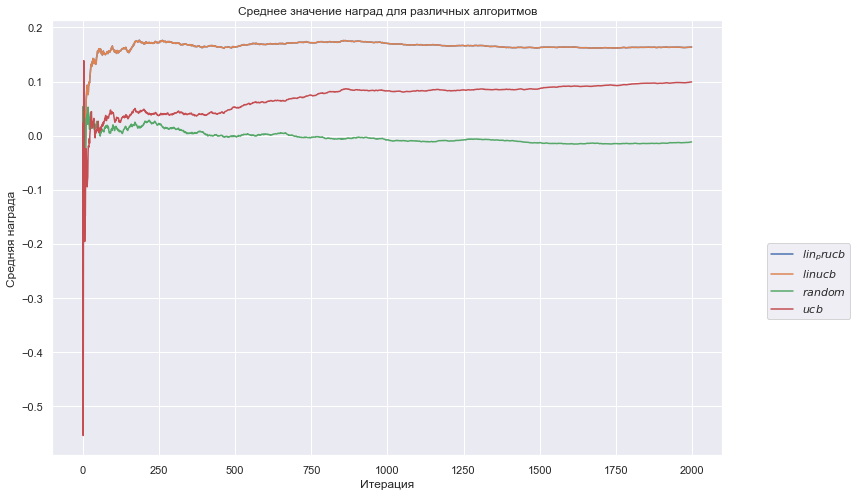

In [480]:
plt.figure(figsize=(12,8))
plt.plot(exp_lin_prucb_with_polinomial.mean_reward, label="$lin_prucb$")
plt.plot(exp_lin_ucb_with_polinomial.mean_reward, label="$linucb$")
plt.plot(exp_random_with_polinomial.mean_reward, label="$random$")
plt.plot(exp_ucb_with_polinomial.mean_reward, label="$ucb$")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Итерация")
plt.title("Среднее значение наград для различных алгоритмов")
plt.ylabel("Средняя награда");

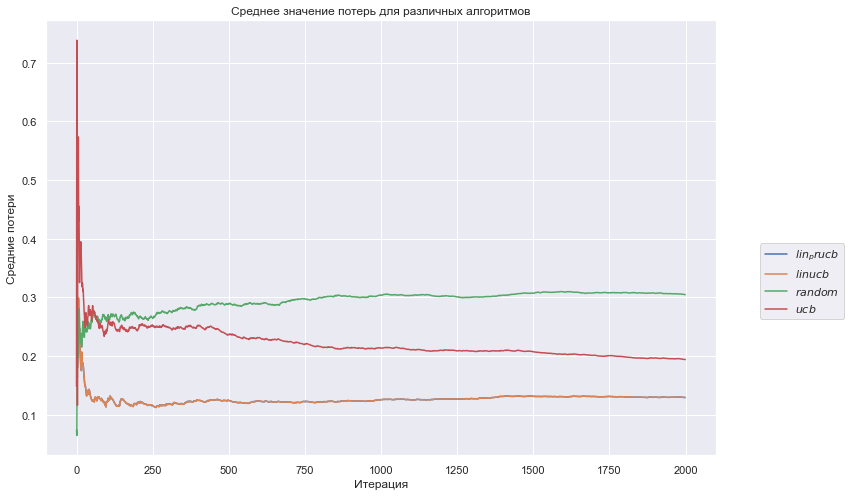

In [488]:
plt.figure(figsize=(12,8))
plt.plot(exp_lin_prucb_with_polinomial.mean_regret, label="$lin_prucb$")
plt.plot(exp_lin_ucb_with_polinomial.mean_regret, label="$linucb$")
plt.plot(exp_random_with_polinomial.mean_regret, label="$random$")
plt.plot(exp_ucb_with_polinomial.mean_regret, label="$ucb$")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Итерация")
plt.title("Среднее значение потерь для различных алгоритмов")
plt.ylabel("Средние потери");

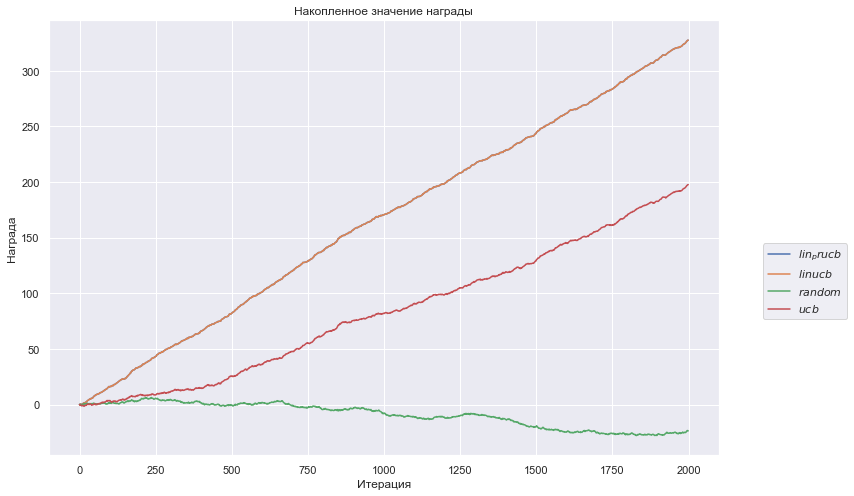

In [482]:
plt.figure(figsize=(12,8))
plt.plot(np.cumsum(exp_lin_prucb_with_polinomial.cumulative_reward), label="$lin_prucb$")
plt.plot(np.cumsum(exp_lin_ucb_with_polinomial.cumulative_reward), label="$linucb$")
plt.plot(np.cumsum(exp_random_with_polinomial.cumulative_reward), label="$random$")
plt.plot(np.cumsum(exp_ucb_with_polinomial.cumulative_reward), label="$ucb$")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Итерация")
plt.title("Накопленное значение награды")
plt.ylabel("Награда");

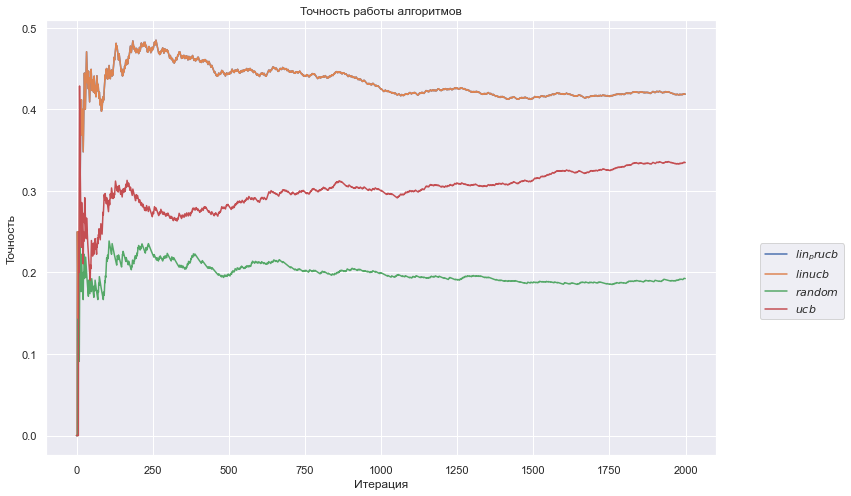

In [483]:
plt.figure(figsize=(12,8))
plt.plot(exp_lin_prucb_with_polinomial.accuracy, label="$lin_prucb$")
plt.plot(exp_lin_ucb_with_polinomial.accuracy, label="$linucb$")
plt.plot(exp_random_with_polinomial.accuracy, label="$random$")
plt.plot(exp_ucb_with_polinomial.accuracy, label="$ucb$")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Итерация")
plt.ylabel("Точность")
plt.title("Точность работы алгоритмов");

## Только со взаимодействиями

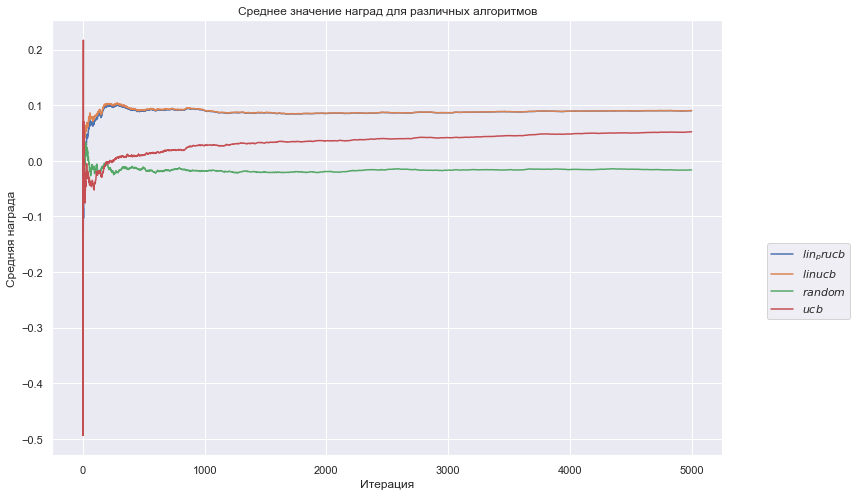

In [484]:
plt.figure(figsize=(12,8))
plt.plot(exp_lin_prucb_int_only.mean_reward, label="$lin_prucb$")
plt.plot(exp_lin_ucb_int_only.mean_reward, label="$linucb$")
plt.plot(exp_random_int_only.mean_reward, label="$random$")
plt.plot(exp_ucb_int_only.mean_reward, label="$ucb$")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Итерация")
plt.title("Среднее значение наград для различных алгоритмов")
plt.ylabel("Средняя награда");

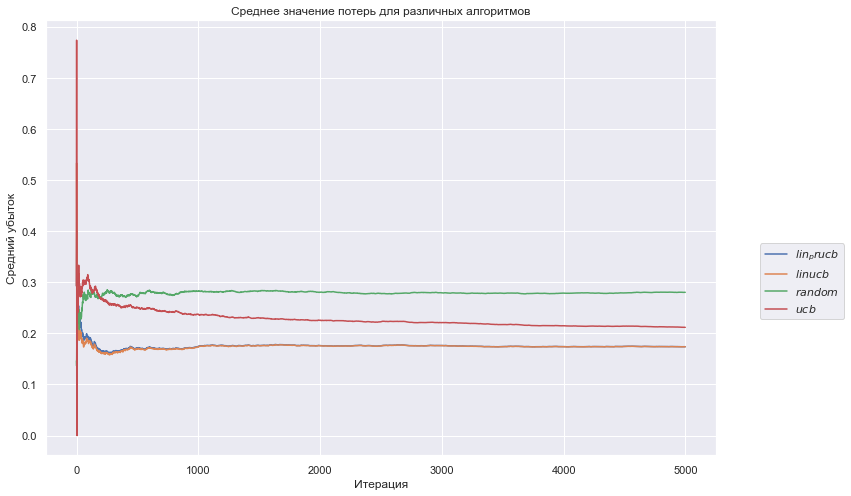

In [485]:
plt.figure(figsize=(12,8))
plt.plot(exp_lin_prucb_int_only.mean_regret, label="$lin_prucb$")
plt.plot(exp_lin_ucb_int_only.mean_regret, label="$linucb$")
plt.plot(exp_random_int_only.mean_regret, label="$random$")
plt.plot(exp_ucb_int_only.mean_regret, label="$ucb$")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Итерация")
plt.title("Среднее значение потерь для различных алгоритмов")
plt.ylabel("Средний убыток");

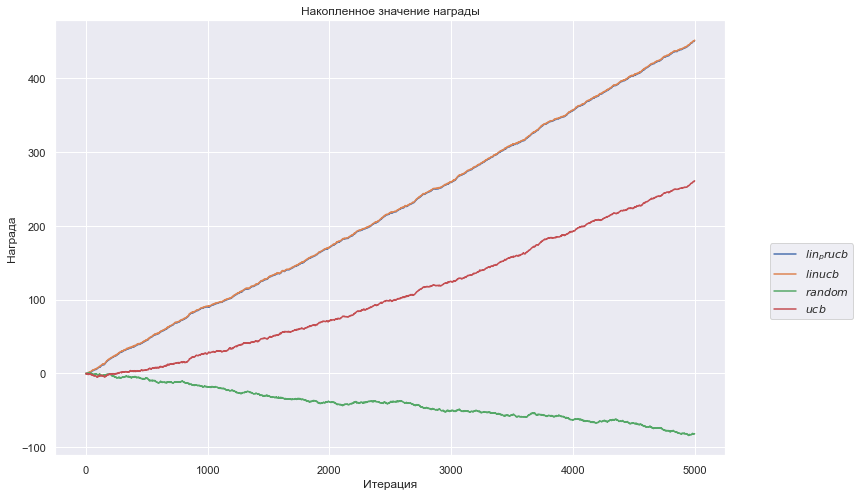

In [486]:
plt.figure(figsize=(12,8))
plt.plot(np.cumsum(exp_lin_prucb_int_only.cumulative_reward), label="$lin_prucb$")
plt.plot(np.cumsum(exp_lin_ucb_int_only.cumulative_reward), label="$linucb$")
plt.plot(np.cumsum(exp_random_int_only.cumulative_reward), label="$random$")
plt.plot(np.cumsum(exp_ucb_int_only.cumulative_reward), label="$ucb$")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Итерация")
plt.title("Накопленное значение награды")
plt.ylabel("Награда");

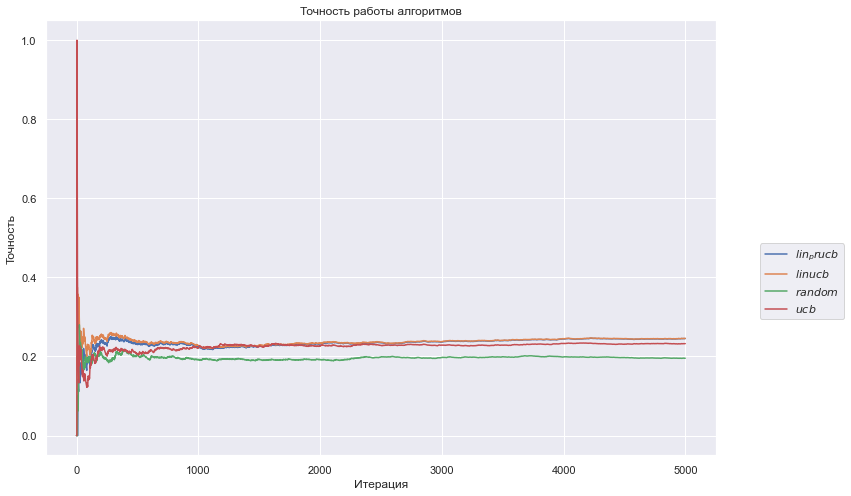

In [487]:
plt.figure(figsize=(12,8))
plt.plot(exp_lin_prucb_int_only.accuracy, label="$lin_prucb$")
plt.plot(exp_lin_ucb_int_only.accuracy, label="$linucb$")
plt.plot(exp_random_int_only.accuracy, label="$random$")
plt.plot(exp_ucb_int_only.accuracy, label="$ucb$")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Итерация")
plt.ylabel("Точность")
plt.title("Точность работы алгоритмов");

### Без полиномов

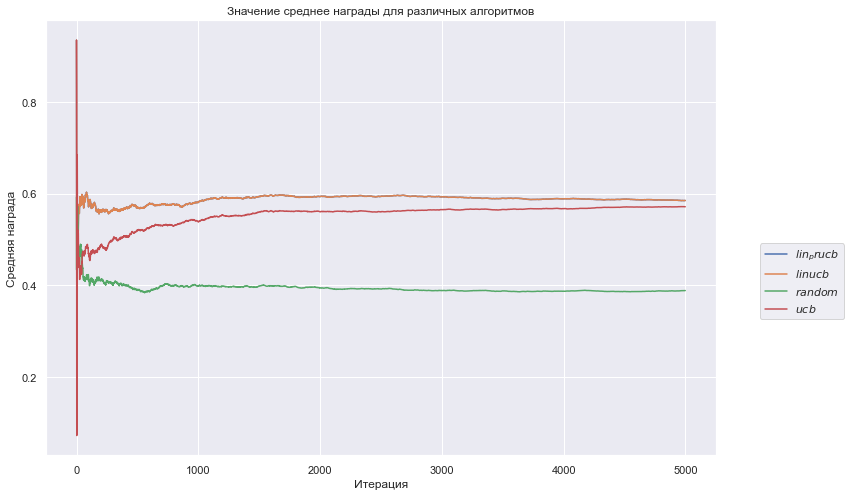

In [454]:
plt.figure(figsize=(12,8))
plt.plot(exp_lin_prucb.mean_reward, label="$lin_prucb$")
plt.plot(exp_lin_ucb.mean_reward, label="$linucb$")
plt.plot(exp_random.mean_reward, label="$random$")
plt.plot(exp_ucb.mean_reward, label="$ucb$")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Итерация")
plt.title("Значение среднее награды для различных алгоритмов")
plt.ylabel("Средняя награда");

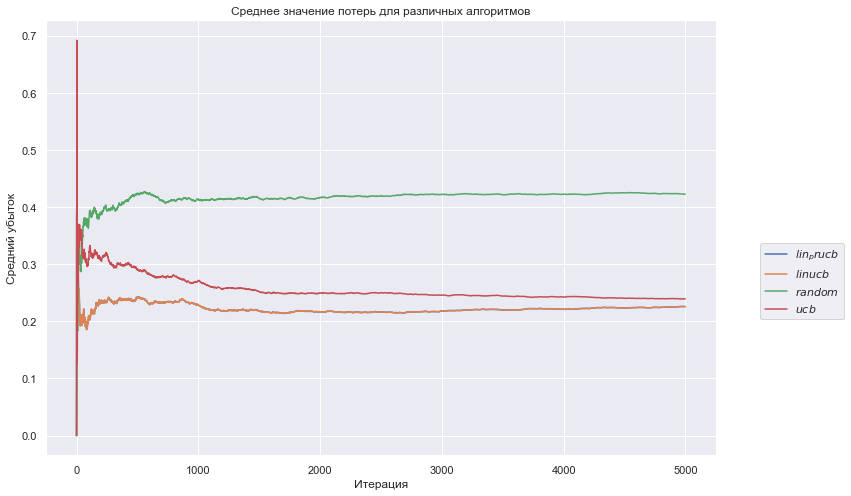

In [489]:
plt.figure(figsize=(12,8))
plt.plot(exp_lin_prucb.mean_regret, label="$lin_prucb$")
plt.plot(exp_lin_ucb.mean_regret, label="$linucb$")
plt.plot(exp_random.mean_regret, label="$random$")
plt.plot(exp_ucb.mean_regret, label="$ucb$")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Итерация")
plt.title("Среднее значение потерь для различных алгоритмов")
plt.ylabel("Средний убыток");

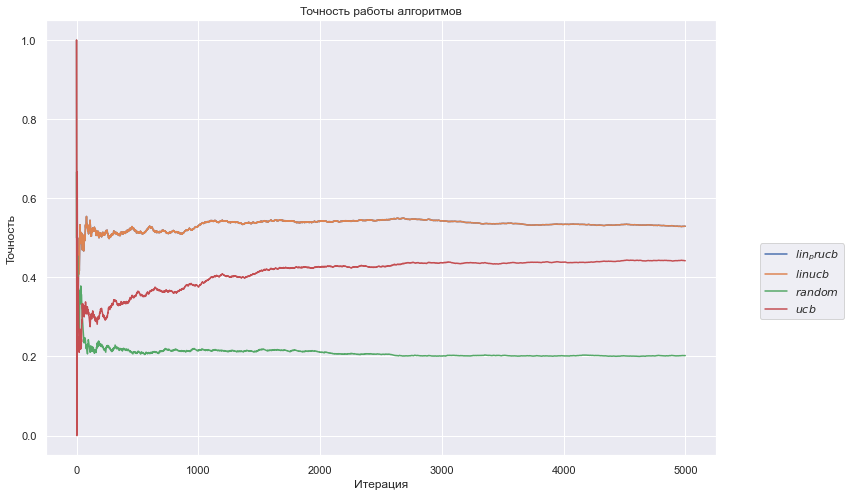

In [450]:
plt.figure(figsize=(12,8))
plt.plot(exp_lin_prucb.accuracy, label="$lin_prucb$")
plt.plot(exp_lin_ucb.accuracy, label="$linucb$")
plt.plot(exp_random.accuracy, label="$random$")
plt.plot(exp_ucb.accuracy, label="$ucb$")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Итерация")
plt.ylabel("Точность")
plt.title("Точность работы алгоритмов");

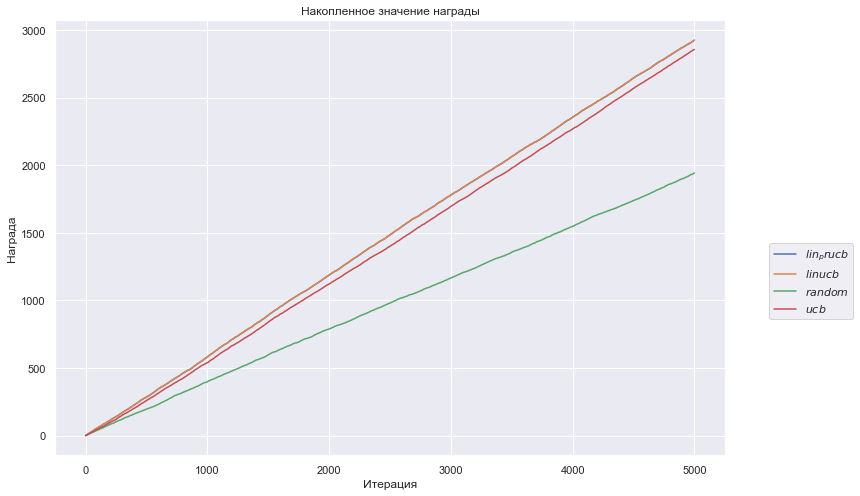

In [461]:
plt.figure(figsize=(12,8))
plt.plot(np.cumsum(exp_lin_prucb.cumulative_reward), label="$lin_prucb$")
plt.plot(np.cumsum(exp_lin_ucb.cumulative_reward), label="$linucb$")
plt.plot(np.cumsum(exp_random.cumulative_reward), label="$random$")
plt.plot(np.cumsum(exp_ucb.cumulative_reward), label="$ucb$")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Итерация")
plt.title("Накопленное значение награды")
plt.ylabel("Награда");

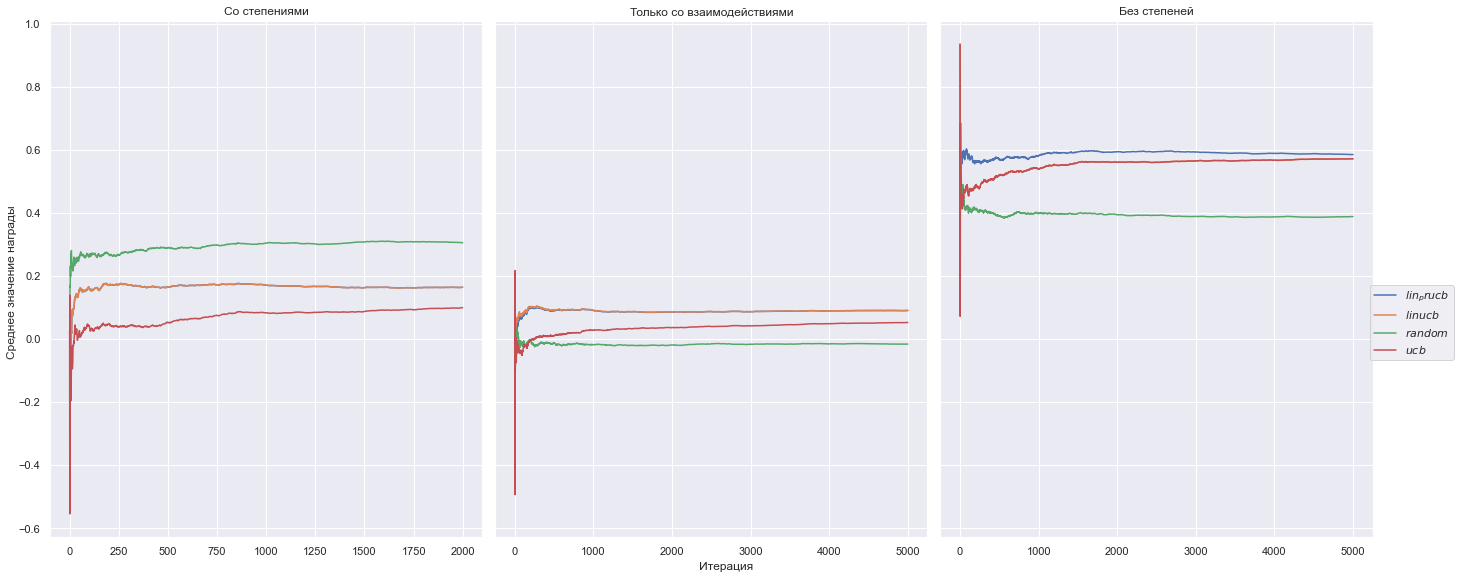

In [522]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(20,8))
axes[2].plot(exp_lin_prucb.mean_reward, label="$lin_prucb$")
axes[2].plot(exp_ucb.mean_reward, label="$linucb$")
axes[2].plot(exp_random.mean_reward, label="$random$")
axes[2].plot(exp_ucb.mean_reward, label="$ucb$")
axes[2].set_title('Без степеней')


axes[1].plot(exp_lin_prucb_int_only.mean_reward, label="$lin_prucb$")
axes[1].plot(exp_lin_ucb_int_only.mean_reward, label="$linucb$")
axes[1].plot(exp_random_int_only.mean_reward, label="$random$")
axes[1].plot(exp_ucb_int_only.mean_reward, label="$ucb$")
axes[1].set_title('Только со взаимодействиями')


axes[0].plot(exp_lin_prucb_with_polinomial.mean_reward, label="$lin_prucb$")
axes[0].plot(exp_lin_ucb_with_polinomial.mean_reward, label="$linucb$")
axes[0].plot(exp_random_with_polinomial.mean_regret, label="$random$")
axes[0].plot(exp_ucb_with_polinomial.mean_reward, label="$ucb$")
axes[0].set_title('Со степениями')

plt.legend(bbox_to_anchor=(1.2, 0.5))
fig.text(0.5, 0.0001, 'Итерация', ha='center')
fig.text(0.001, 0.5, 'Среднее значение награды', va='center', rotation='vertical')
fig.tight_layout()

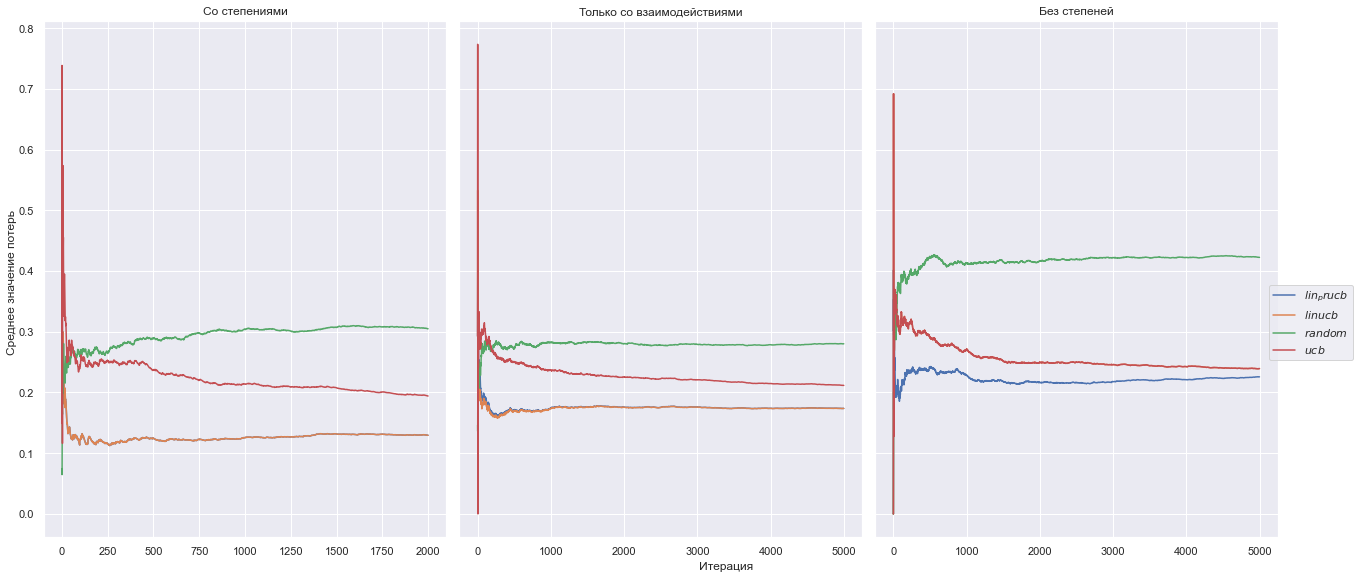

In [521]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(20,8))
axes[2].plot(exp_lin_prucb.mean_regret, label="$lin_prucb$")
axes[2].plot(exp_ucb.mean_regret, label="$linucb$")
axes[2].plot(exp_random.mean_regret, label="$random$")
axes[2].plot(exp_ucb.mean_regret, label="$ucb$")
axes[2].set_title('Без степеней')


axes[1].plot(exp_lin_prucb_int_only.mean_regret, label="$lin_prucb$")
axes[1].plot(exp_lin_ucb_int_only.mean_regret, label="$linucb$")
axes[1].plot(exp_random_int_only.mean_regret, label="$random$")
axes[1].plot(exp_ucb_int_only.mean_regret, label="$ucb$")
axes[1].set_title('Только со взаимодействиями')


axes[0].plot(exp_lin_prucb_with_polinomial.mean_regret, label="$lin_prucb$")
axes[0].plot(exp_lin_ucb_with_polinomial.mean_regret, label="$linucb$")
axes[0].plot(exp_random_with_polinomial.mean_regret, label="$random$")
axes[0].plot(exp_ucb_with_polinomial.mean_regret, label="$ucb$")
axes[0].set_title('Со степениями')

plt.legend(bbox_to_anchor=(1.2, 0.5))
fig.text(0.5, 0.0001, 'Итерация', ha='center')
fig.text(0.001, 0.5, 'Среднее значение потерь', va='center', rotation='vertical')
fig.tight_layout()

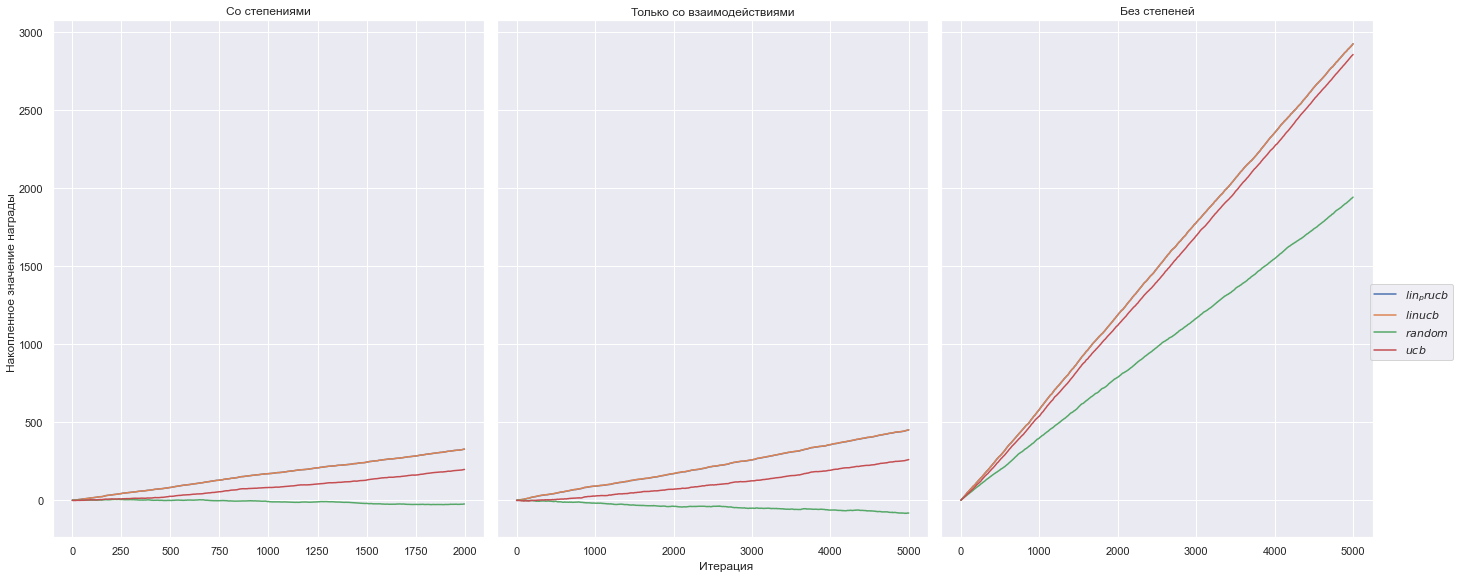

In [520]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(20,8))
axes[2].plot(np.cumsum(exp_lin_prucb.cumulative_reward), label="$lin_prucb$")
axes[2].plot(np.cumsum(exp_lin_ucb.cumulative_reward), label="$linucb$")
axes[2].plot(np.cumsum(exp_random.cumulative_reward), label="$random$")
axes[2].plot(np.cumsum(exp_ucb.cumulative_reward), label="$ucb$")
axes[2].set_title('Без степеней')


axes[1].plot(np.cumsum(exp_lin_prucb_int_only.cumulative_reward), label="$lin_prucb$")
axes[1].plot(np.cumsum(exp_lin_ucb_int_only.cumulative_reward), label="$linucb$")
axes[1].plot(np.cumsum(exp_random_int_only.cumulative_reward), label="$random$")
axes[1].plot(np.cumsum(exp_ucb_int_only.cumulative_reward), label="$ucb$")
axes[1].set_title('Только со взаимодействиями')

axes[0].plot(np.cumsum(exp_lin_prucb_with_polinomial.cumulative_reward), label="$lin_prucb$")
axes[0].plot(np.cumsum(exp_lin_ucb_with_polinomial.cumulative_reward), label="$linucb$")
axes[0].plot(np.cumsum(exp_random_with_polinomial.cumulative_reward), label="$random$")
axes[0].plot(np.cumsum(exp_ucb_with_polinomial.cumulative_reward), label="$ucb$")
axes[0].set_title('Со степениями')

plt.legend(bbox_to_anchor=(1.2, 0.5))
fig.text(0.5, 0.001, 'Итерация', ha='center')
fig.text(0.001, 0.5, 'Накопленное значение награды', va='center', rotation='vertical')
fig.tight_layout()
